# Análisis de Series Temporales
#### Segundo Trabajo Práctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 16 de Agosto de 2025  
**Descripción:** Forecast en variables macroeconómicas

# Faena vacuna en Argentina

## 1. Introducción
Este trabajo práctico analiza la serie temporal **"Faena vacuna en Argentina"**, con datos mensuales desde febrero de 1998 hasta mayo de 2025 medidos en cabezas de ganado. El objetivo es modelar la serie usando distintas técnicas de Machine Learning y Deep Learning, comparando su desempeño entre sí y con los modelos SARIMA obtenidos en el trabajo anterior, y generar pronósticos a 12 meses.

## 2. Carga e importación de librerías necesarias

In [ ]:
# pip install tensorflow keras scikit-learn pandas numpy matplotlib statsmodels

In [ ]:
# ==================== IMPORTS  ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings
warnings.filterwarnings('ignore')

# Estadística y Series Temporales
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest

# Machine Learning - Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_array, check_X_y

# Machine Learning - Otros
import lightgbm as lgb
import xgboost as xgb
from prophet import Prophet


# EDA y Visualización
from ydata_profiling import ProfileReport
from matplotlib.patches import Rectangle

# Utilidades
from math import sqrt

----
## 3. Carga y exploración de los datos

In [30]:
# Cargar datasets
df_faena = pd.read_csv('faena-pecuaria-por-especies-valores-mensuales.csv')

In [31]:
df_faena = df_faena[['indice_tiempo', 'vacunos_cabezas']]
df_faena.set_index('indice_tiempo', inplace=True)
df_faena = df_faena.iloc[217:]
df_faena.index.freq = 'MS'  # Frecuencia mensual
df_faena.head()

,vacunos_cabezas
indice_tiempo,
1998-02-01,889530.0
1998-03-01,992968.0
1998-04-01,936164.0
1998-05-01,912879.0
1998-06-01,909223.0


In [32]:
# Verificamos
print(df_faena.info())

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 1998-02-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vacunos_cabezas  328 non-null    float64
dtypes: float64(1)
memory usage: 5.1+ KB
None


### Profile reporting

In [33]:
# Creamos un df para el EDA automático
df_merged_profile = df_faena.reset_index()

In [34]:
import matplotlib
matplotlib.use('Agg')  

In [35]:
# Creamos Reporte 
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df_merged_profile,
    title="EDA: Faena Vacuna",
    explorative=True,
    interactions={"continuous": False}  
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 57.95it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Estadísticas descriptivas

In [36]:
s = df_faena['vacunos_cabezas']

# Describe con percentiles adicionales
percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
desc = s.describe(percentiles=percentiles)
print(desc)

# Skewness (asimetría) y kurtosis
print(f"Skewness : {s.skew():.4f}")
print(f"Kurtosis : {s.kurtosis():.4f}")

# Coeficiente de variación (std / mean)
cv = s.std() / s.mean()
print(f"Coef. variación: {cv:.4f}")

count    3.280000e+02
mean     1.083363e+06
std      1.316603e+05
min      7.220240e+05
1%       8.575030e+05
25%      9.833659e+05
50%      1.061730e+06
75%      1.178836e+06
99%      1.414593e+06
max      1.458327e+06
Name: vacunos_cabezas, dtype: float64
Skewness : 0.4207
Kurtosis : -0.3062
Coef. variación: 0.1215


### Gráficos de las series 

In [37]:
%matplotlib inline

In [38]:
# Creamos una función que grafica automáticamente las series
def graficar(
    df, 
    column, 
    titulo='', 
    xlabel='Año', 
    ylabel='', 
    figsize=(10, 4), 
    usar_leyenda=True, 
    label=None, 
    color=None
):
    ts = df[column]
    plt.figure(figsize=figsize)
    plt.plot(
        ts.index, 
        ts.values, 
        label=label or column, 
        color=color
    )
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if usar_leyenda:
        plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

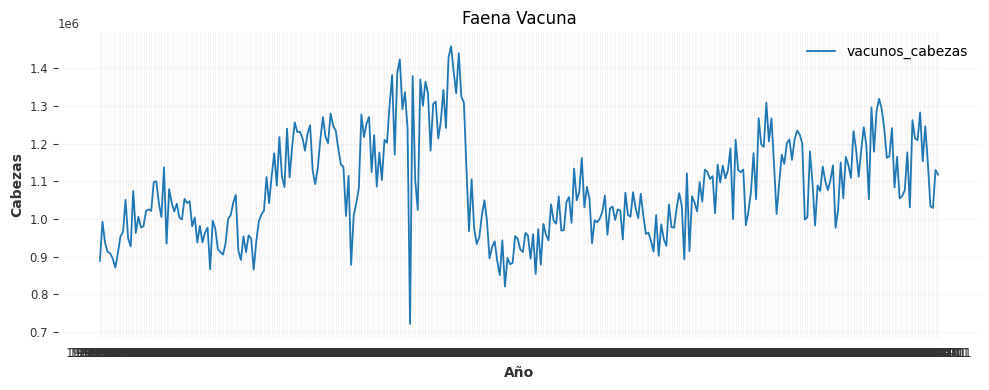

In [39]:
# 1. Gráfico solo de las importaciones
graficar(
    df_faena, 
    'vacunos_cabezas',
    titulo='Faena Vacuna',
    ylabel='Cabezas',
    color='tab:blue'
)

### Descomposición de la serie en sus componentes

##### Additive

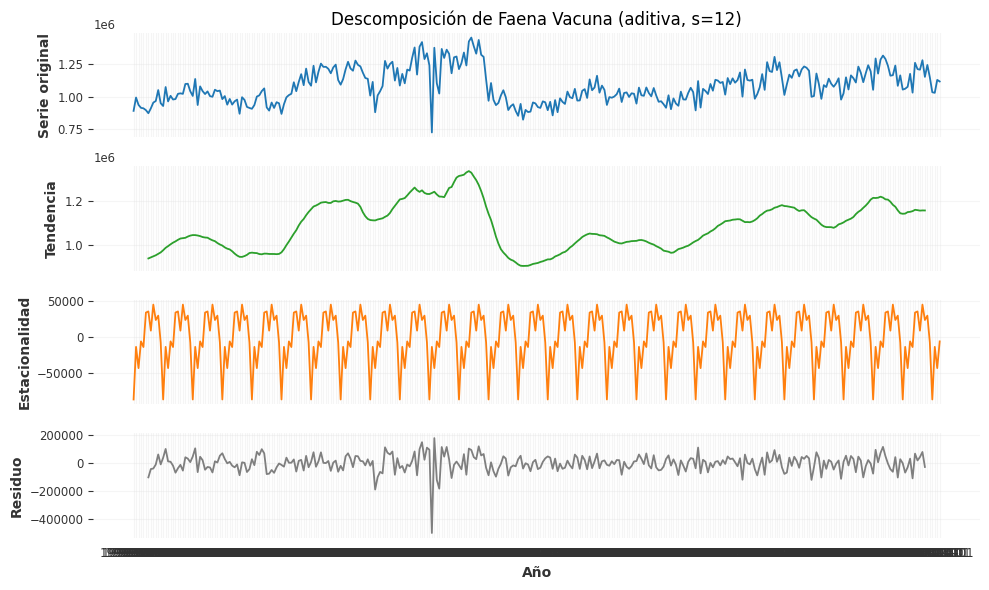

In [40]:
# Descomposición aditiva de vacunos_cabezas (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_faena['vacunos_cabezas'], 
    model='additive', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposición de Faena Vacuna (aditiva, s=12)', fontsize=12)

# Etiqueta común para el eje X
axes[-1].set_xlabel('Año')

plt.tight_layout()
plt.show()

##### Multiplicative

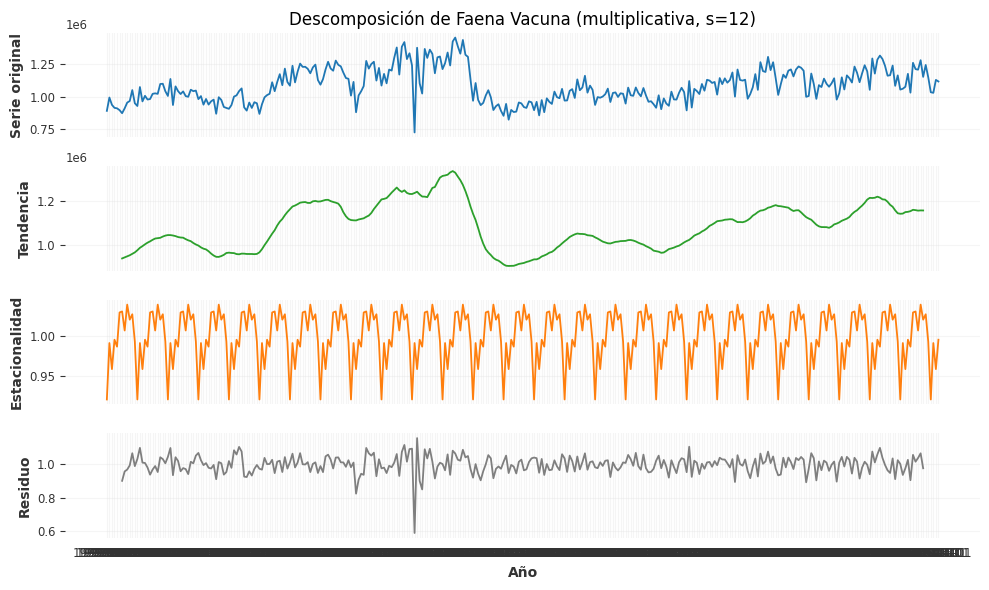

In [41]:
# Descomposición multiplicativa de Faena Vacuna (periodo = 12 meses)
decomp_imp = seasonal_decompose(
    df_faena['vacunos_cabezas'], 
    model='multiplicative', 
    period=12
)

# Configurar figura con 4 subplots (observada, tendencia, estacional, residuo)
fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

componentes = ['observed', 'trend', 'seasonal', 'resid']
titulos     = ['Serie original', 'Tendencia', 'Estacionalidad', 'Residuo']
colores     = ['tab:blue',    'tab:green', 'tab:orange',      'tab:gray']

for i, (comp, titulo, color) in enumerate(zip(componentes, titulos, colores)):
    serie = getattr(decomp_imp, comp)
    axes[i].plot(serie, color=color)
    axes[i].set_ylabel(titulo, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_title('Descomposición de Faena Vacuna (multiplicativa, s=12)', fontsize=12)

# Etiqueta común para el eje X
axes[-1].set_xlabel('Año')

plt.tight_layout()
plt.show()

Al comparar ambas descomposiciones de la serie de Faena Vacuna, se observa que la descomposición multiplicativa resulta más apropiada para este conjunto de datos. La principal diferencia radica en que el modelo multiplicativo presenta el componente estacional en escala relativa (0.95-1.05) representando proporciones, mientras que el modelo aditivo lo hace en escala absoluta (-50,000 a +50,000) como cantidades fijas. Esta distinción es crucial porque en la serie de faena vacuna la estacionalidad varía proporcionalmente con el nivel de la serie: los picos y valles estacionales son más pronunciados durante períodos de alta actividad (como 2007-2008) y menos pronunciados en niveles bajos. Además, los residuos del modelo multiplicativo (escala 0.6-1.2) son más homogéneos y estables a lo largo del tiempo comparados con los del modelo aditivo (-400,000 a +200,000), lo que indica un mejor ajuste. 

Esta característica es típica de series económicas donde la estacionalidad es función del nivel de actividad y no una cantidad constante, por lo que la descomposición multiplicativa captura de manera más fidedigna la estructura subyacente de los datos.

### Análisis de Outliers

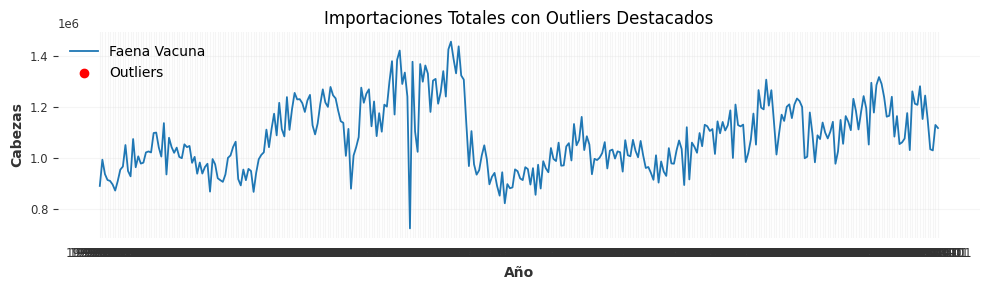

In [42]:
# 1) Calculamos los umbrales IQR sobre importaciones_total
Q1 = df_faena['vacunos_cabezas'].quantile(0.25)
Q3 = df_faena['vacunos_cabezas'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_faena['vacunos_cabezas'] < limite_inf) |
    (df_faena['vacunos_cabezas'] > limite_sup)
)

# 3) Gráfico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_faena.index,
    df_faena['vacunos_cabezas'],
    label='Faena Vacuna',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_faena.index[mask_outliers],
    df_faena.loc[mask_outliers, 'vacunos_cabezas'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Importaciones Totales con Outliers Destacados')
plt.xlabel('Año')
plt.ylabel('Cabezas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como con k=1.5 no se detectan outliers pero claramente hay un pico anómalo en 2008, se vuelva a repetir pero tomando k=1 siendo este un criterio más estricto

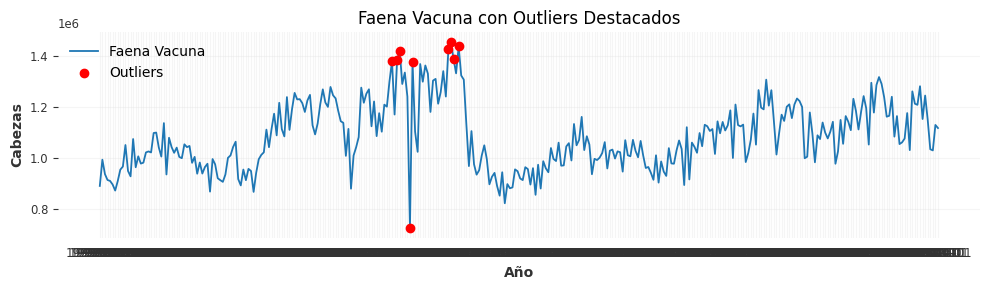

In [43]:
# Cambiamos el umbral para que sea k=1
Q1 = df_faena['vacunos_cabezas'].quantile(0.25)
Q3 = df_faena['vacunos_cabezas'].quantile(0.75)
IQR = Q3 - Q1
limite_inf = Q1 - 1 * IQR
limite_sup = Q3 + 1* IQR

# 2) Detectamos outliers
mask_outliers = (
    (df_faena['vacunos_cabezas'] < limite_inf) |
    (df_faena['vacunos_cabezas'] > limite_sup)
)

# 3) Gráfico
plt.figure(figsize=(10, 3))
# Serie completa
plt.plot(
    df_faena.index,
    df_faena['vacunos_cabezas'],
    label='Faena Vacuna',
    color='tab:blue'
)
# Puntos outliers
plt.scatter(
    df_faena.index[mask_outliers],
    df_faena.loc[mask_outliers, 'vacunos_cabezas'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title('Faena Vacuna con Outliers Destacados')
plt.xlabel('Año')
plt.ylabel('Cabezas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Ahora si se detectan outliers entre 2007 y 2009 aproximadamente. De todos modos, dado que se van a implementar distintos modelos de Machine Learning y Deep Learning, se decide no tomar ninguna medida sobre ellos a priori ya que son modelos menos sensibles a los valores atípicos.

-----
## 4. Modelos

Emplearemos una estrategia de validación basada en **TimeSeriesSplit (Cross Validation Time Series)** porque, a diferencia de un simple particionado aleatorio “train/test”, esta metodología respeta la estructura cronológica de los datos y evita el problema de data leakage, es decir, que información futura contamine la fase de entrenamiento. Al generar pliegues crecientes donde cada iteración entrena sobre todos los meses previos y valida sobre un bloque posterior (por ejemplo, 12 meses), simulamos de manera fiel el escenario de producción “mes a mes” en el que un modelo entrenado hasta el mes t debe predecir el mes t+1. Esto nos permite evaluar de forma más robusta la estabilidad y capacidad de generalización de cada algoritmo, comparar objetivamente sus performances y ajustar hiperparámetros con metodologías como grid‐search sin incurrir en sesgos.
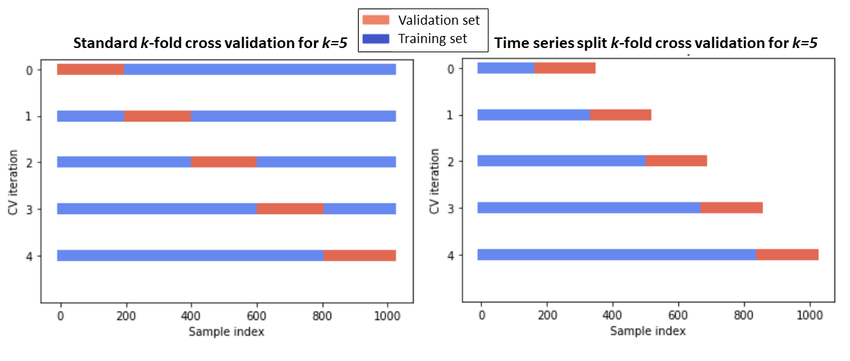

> ## 1. Modelo base: SARIMA(1,1,1)(0,1,2)[12]

Como benchmark, emplearemos el modelo SARIMA(1,1,1)(0,1,2)[12] sin término constante para comparar el desempeño de nuestros algoritmos de machine learning ya que este fue el modelo con mejor rendimiento seleccionado en el primer trabajo de la materia. Este modelo SARIMA, al ser un método estadístico clásico, proporciona una aproximación parsimoniosa y altamente interpretable. Sin embargo, su naturaleza inherentemente lineal y su estructura rígida limitan su capacidad para capturar relaciones no lineales, interacciones complejas y patrones de alta dimensionalidad presentes en los datos.

Por lo tanto, nuestra estrategia metodológica implica deliberadamente sacrificar parte de la interpretabilidad y simplicidad que ofrecen los modelos tradicionales a cambio de una mayor capacidad predictiva, recurriendo a modelos de mayor complejidad como redes neuronales (ANN, NNAR, RNN) y métodos de ensamblado (XGBoost, LightGBM, Prophet). Este enfoque nos permite identificar relaciones más complejas y potencialmente obtener pronósticos más precisos.

In [44]:
# Función de MAPE mejorada que maneja diferentes tipos de datos
def mape(y_true, y_pred):
    # Convertir a arrays de numpy para evitar problemas de indexación
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Evitar división por cero
    mask = y_true != 0
    if mask.sum() == 0:  # Si todos los valores son cero
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Función alternativa: sMAPE (symmetric MAPE) - más robusta
def smape(y_true, y_pred):
    # Convertir a arrays de numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100


In [45]:
# Definir órdenes del modelo SARIMA directamente
order = (1, 1, 1)
seasonal_order = (0, 1, 2, 12)

print("Órdenes utilizados:", order, seasonal_order)

Órdenes utilizados: (1, 1, 1) (0, 1, 2, 12)


In [46]:
# Variable objetivo
y_full = df_faena['vacunos_cabezas']

In [47]:
# Verificar si hay valores cero o negativos
print(f"Valores cero en la serie: {(y_full == 0).sum()}")
print(f"Valores negativos en la serie: {(y_full < 0).sum()}")
print(f"Estadísticas de la serie:")
print(y_full.describe())

Valores cero en la serie: 0
Valores negativos en la serie: 0
Estadísticas de la serie:
count    3.280000e+02
mean     1.083363e+06
std      1.316603e+05
min      7.220240e+05
25%      9.833659e+05
50%      1.061730e+06
75%      1.178836e+06
max      1.458327e+06
Name: vacunos_cabezas, dtype: float64


In [48]:
# Validación con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
mape_scores = []
smape_scores = []
rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), 1):
    # Split
    y_train = y_full.iloc[train_idx]
    y_test  = y_full.iloc[test_idx]

    try:
        # Ajuste SARIMA con los órdenes fijos (sin exógenas)
        model = SARIMAX(
            endog=y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Pronóstico para los próximos len(test_idx) meses
        y_pred = model.forecast(steps=len(test_idx))

        # Métricas en escala original
        m = mape(y_test, y_pred)
        sm = smape(y_test, y_pred)
        r = np.sqrt(mean_squared_error(y_test, y_pred))
        
        mape_scores.append(m)
        smape_scores.append(sm)
        rmse_scores.append(r)

        print(f"Fold {fold} → MAPE = {m:.2f}%,  sMAPE = {sm:.2f}%,  RMSE = {r:.2f}")
    
    except Exception as e:
        print(f"Fold {fold} → Error en el ajuste: {e}")
        mape_scores.append(np.nan)
        smape_scores.append(np.nan)
        rmse_scores.append(np.nan)

Fold 1 → MAPE = 6.19%,  sMAPE = 5.88%,  RMSE = 89988.47
Fold 2 → MAPE = 4.22%,  sMAPE = 4.30%,  RMSE = 60652.47
Fold 3 → MAPE = 5.36%,  sMAPE = 5.50%,  RMSE = 78674.89
Fold 4 → MAPE = 11.29%,  sMAPE = 10.50%,  RMSE = 146821.68
Fold 5 → MAPE = 6.39%,  sMAPE = 6.49%,  RMSE = 86759.68


In [49]:
# Métricas promedio del modelo SARIMA
print(f"\nMAPE promedio: {np.nanmean(mape_scores):.2f}%")
print(f"sMAPE promedio: {np.nanmean(smape_scores):.2f}%")
print(f"RMSE promedio: {np.nanmean(rmse_scores):.2f}")


MAPE promedio: 6.69%
sMAPE promedio: 6.54%
RMSE promedio: 92579.44


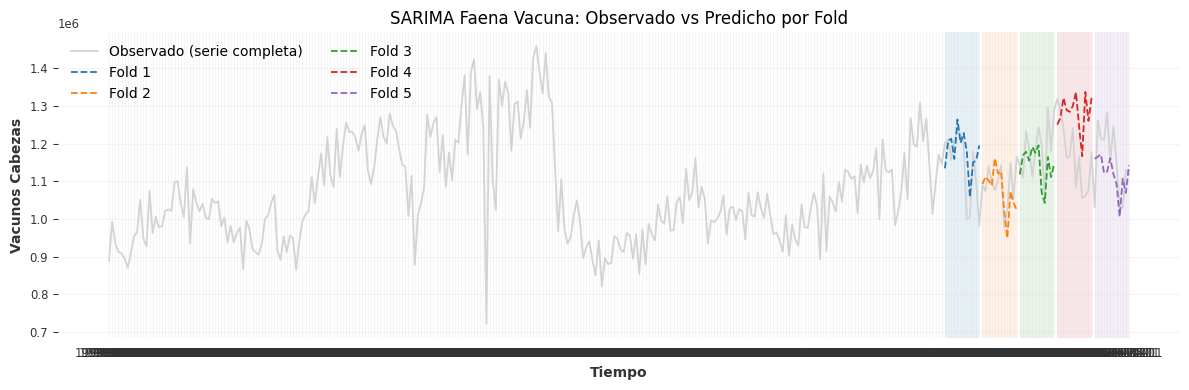

In [50]:
# Gráfico de observado vs predicho sobre el conjunto de validación por cada fold
colors = plt.get_cmap('tab10').colors

# Prepara figura
fig, ax = plt.subplots(figsize=(12,4))
# Serie observada completa en gris claro - usar el índice del DataFrame (que es indice_tiempo)
ax.plot(df_faena.index, y_full, color='lightgray', label='Observado (serie completa)')

# Recorre cada fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(y_full), start=1):
    try:
        # Partición
        y_train   = y_full.iloc[train_idx]
        y_test    = y_full.iloc[test_idx]
        idx_test  = df_faena.index[test_idx]  # El índice es indice_tiempo

        # Ajusta SARIMA con tus órdenes
        model = SARIMAX(
            endog=y_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Pronóstico sobre el block de test
        y_pred = model.forecast(steps=len(test_idx))
        
        # Color y sombreado
        c = colors[(fold-1) % len(colors)]
        ax.axvspan(idx_test[0], idx_test[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_test, y_pred, linestyle='--', color=c, label=f'Fold {fold}')
    
    except Exception as e:
        print(f"Error en gráfico del Fold {fold}: {e}")

# Ajustes finales
ax.set_title('SARIMA Faena Vacuna: Observado vs Predicho por Fold', fontsize=12)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Vacunos Cabezas')
ax.legend(loc='upper left', ncol=2, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
# Ajustes finales
ax.set_title('SARIMA: Observado vs Predicho por Fold (CV)', fontsize=12)
ax.set_xlabel('Tiempo')
ax.set_ylabel('Vacunos Cabezas')
ax.legend(loc='upper left', ncol=2, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Ajuste final sobre la serie completa
try:
    final_model = SARIMAX(
        endog=df_faena['vacunos_cabezas'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Imprimir el resumen
    print(final_model.summary())

except Exception as e:
    print(f"Error en el modelo final: {e}")

<Figure size 640x480 with 0 Axes>

                                        SARIMAX Results                                        
Dep. Variable:                         vacunos_cabezas   No. Observations:                  328
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3703.443
Date:                                 Sat, 16 Aug 2025   AIC                           7416.885
Time:                                         15:28:14   BIC                           7435.218
Sample:                                     02-01-1998   HQIC                          7424.231
                                          - 05-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2797      0.122     -2.288      0.022      -0.519      -0

En las siguientes etapas exploraremos modelos de machine learning (XGBoost, LightGBM, ANN, RNN, Prophet, etc.) que, a costa de renunciar algo de parsimonia y explicabilidad, podrían capturar relaciones no lineales y mejorar aún más la calidad de los pronósticos.

----
> ## 2. Modelo *Artificial Neural Network*

==================== MODELOS ARTIFICIAL NEURAL NETWORK (ANN) ====================

Las Redes Neuronales Artificiales son modelos computacionales inspirados en el funcionamiento del cerebro humano, compuestos por múltiples capas de neuronas artificiales interconectadas. Para series temporales, ofrecen ventajas significativas sobre métodos tradicionales como:

🧠 CARACTERÍSTICAS PRINCIPALES:
• Capacidad de capturar relaciones NO LINEALES complejas en los datos
• Aprendizaje automático de patrones sin especificación previa de la estructura
• Flexibilidad para manejar múltiples variables explicativas (lags, features estacionales)
• Robustez ante outliers y cambios estructurales en la serie

⚙️ ARQUITECTURA:
• Capa de entrada: Recibe las variables explicativas (lags, features temporales)
• Capas ocultas: Procesan la información mediante funciones de activación no lineales
• Capa de salida: Genera la predicción final
• Pesos y sesgos: Parámetros que se ajustan durante el entrenamiento

🔧 FEATURE ENGINEERING PARA ANN:
El éxito de las ANN en series temporales depende crucialmente del diseño de features:

• LAGS AUTORREGRESIVOS: Variables rezagadas (cab_lag1, cab_lag2, ..., cab_lag6) que capturan la dependencia temporal de la serie con sus valores pasados

• ESTADÍSTICAS MÓVILES: 
  - Rolling means (cab_ma3, cab_ma6): Suavizan tendencias de corto plazo
  - Rolling std (cab_std3, cab_std6): Capturan volatilidad cambiante

• VARIABLES TEMPORALES:
  - Month (1-12): Estacionalidad mensual
  - Quarter (1-4): Patrones trimestrales 
  - Trimester (1-3): Agrupaciones de 4 meses para ciclos específicos

• ESCALADO DE FEATURES: StandardScaler normaliza todas las variables para facilitar la convergencia y evitar dominancia de variables con mayor escala

Esta ingeniería de características permite que la ANN identifique patrones  autorregresivos, estacionales y de volatilidad de forma simultánea.

📊 OPTIMIZACIÓN DE HIPERPARÁMETROS:
Las ANN requieren ajuste meticuloso de múltiples hiperparámetros para maximizar su rendimiento predictivo:

• ARQUITECTURA DE RED:
  - hidden_layer_sizes: Número y tamaño de capas ocultas [(50,), (100,), (150,), (100,50)]
  - Determina la capacidad de modelado y complejidad del modelo

• PARÁMETROS DE ENTRENAMIENTO:
  - learning_rate_init: Velocidad de aprendizaje [1e-3, 1e-2, 3e-2]
  - alpha: Regularización L2 para prevenir sobreajuste [1e-3, 1e-2, 3e-2]
  - max_iter: Iteraciones máximas de entrenamiento

• ESTRATEGIA DE OPTIMIZACIÓN:
  - GridSearchCV con TimeSeriesSplit: Búsqueda exhaustiva respetando orden temporal
  - Validación cruzada específica para series temporales (sin data leakage)
  - Refit por MAPE: Optimización enfocada en error porcentual

• REGULARIZACIÓN Y CONTROL:
  - early_stopping: Detiene entrenamiento cuando no hay mejoras
  - validation_fraction: Porción de datos para validación interna
  - Previene sobreajuste y mejora generalización

📈 VENTAJAS EN SERIES TEMPORALES:
• Modelado de estacionalidades complejas y cambiantes
• Detección automática de interacciones entre variables
• Capacidad de aproximar cualquier función continua (teorema de aproximación universal)
• Adaptabilidad a diferentes tipos de patrones temporales
• Integración natural de múltiples tipos de features (lags, estacionales, volatilidad)

⚠️ CONSIDERACIONES:
• Requiere mayor cantidad de datos para entrenamiento efectivo
• Menor interpretabilidad comparado con modelos estadísticos tradicionales
• Riesgo de sobreajuste sin regularización adecuada
• Sensibilidad a la calidad del feature engineering
• Necesidad de validación temporal específica (TimeSeriesSplit)

🎯 IMPLEMENTACIÓN EN ESTE ANÁLISIS:
1. MLP Básico: Configuración simple con parámetros por defecto
2. MLP Optimizado: Hiperparámetros ajustados mediante Grid Search exhaustivo
3. MLP Profundo: Arquitectura multicapa (128-64-32-16) para patrones complejos

In [52]:
# Configurar semillas para reproducibilidad
np.random.seed(123)
# tf.random.set_seed(123)  # ← COMENTAR ESTA LÍNEA

# Monkey-patch para MLPRegressor
def _validate_data(self, X, y=None, reset=True, **kwargs):
    if y is None:
        return check_array(X)
    return check_X_y(X, y)

MLPRegressor._validate_data = _validate_data

In [53]:
# ==================== FEATURE ENGINEERING ====================
print("="*60)
print("INICIANDO FEATURE ENGINEERING")
print("="*60)

# Preparar el dataset
df_feat = df_faena.copy()

# Configurar índice temporal
if 'indice_tiempo' in df_feat.columns:
    df_feat['indice_tiempo'] = pd.to_datetime(df_feat['indice_tiempo'])
    df_feat.set_index('indice_tiempo', inplace=True)

df_feat.index = pd.to_datetime(df_feat.index)

print(f"DataFrame inicial: {df_feat.shape}")
print(f"Columnas disponibles: {df_feat.columns.tolist()}")
print(f"Rango de fechas: {df_feat.index.min()} a {df_feat.index.max()}")

INICIANDO FEATURE ENGINEERING
DataFrame inicial: (328, 1)
Columnas disponibles: ['vacunos_cabezas']
Rango de fechas: 1998-02-01 00:00:00 a 2025-05-01 00:00:00



ANÁLISIS ACF/PACF


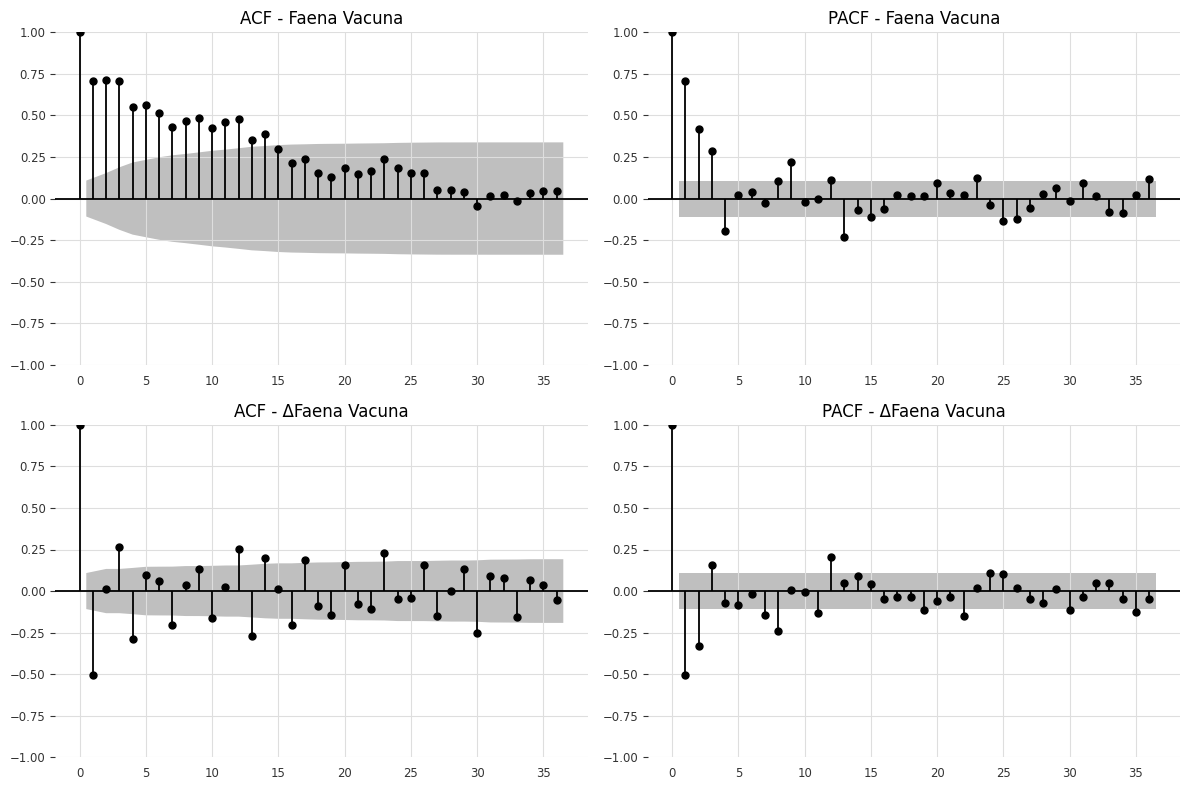

In [54]:
# ==================== ANÁLISIS ACF/PACF ====================
print("\n" + "="*40)
print("ANÁLISIS ACF/PACF")
print("="*40)

series = df_feat['vacunos_cabezas']
series_diff = series.diff().dropna()
max_lags = 36

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF y PACF de la serie original
plot_acf(series, lags=max_lags, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Faena Vacuna')
plot_pacf(series, lags=max_lags, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Faena Vacuna')

# ACF y PACF de la serie diferenciada
plot_acf(series_diff, lags=max_lags, ax=axes[1, 0])
axes[1, 0].set_title('ACF - ΔFaena Vacuna')
plot_pacf(series_diff, lags=max_lags, ax=axes[1, 1])
axes[1, 1].set_title('PACF - ΔFaena Vacuna')

plt.tight_layout()
plt.show()

In [55]:
# ==================== CREACIÓN DE FEATURES ====================
print("\n" + "="*40)
print("CREANDO FEATURES")
print("="*40)

# 1) LAGS de vacunos_cabezas (componente autorregresivo)
print("1) Creando lags...")
for lag in range(1, 7):
    df_feat[f'cab_lag{lag}'] = df_feat['vacunos_cabezas'].shift(lag)

print(f"   Lags creados: cab_lag1 a cab_lag6")

# 2) Estadísticas móviles (rolling mean y std)
print("2) Creando estadísticas móviles...")
for window in [3, 6]:
    # Rolling window: El shift(1) es para no incluir la propia variable target en el momento t, dentro de las variables features. 
    # Sino, estaría -de una manera indirecta, porque esta incluída en esta ventana de media móvil- y(t) explicando a y(t).
    df_feat[f'cab_ma{window}'] = df_feat['vacunos_cabezas'].shift(1).rolling(window).mean()
    df_feat[f'cab_std{window}'] = df_feat['vacunos_cabezas'].shift(1).rolling(window).std()

print(f"   Rolling stats creadas: cab_ma3, cab_ma6, cab_std3, cab_std6")

# 3) Variables de calendario
print("3) Creando variables de calendario...")
df_feat['month'] = df_feat.index.month
df_feat['quarter'] = df_feat.index.quarter
df_feat['trimester'] = ((df_feat.index.month - 1) // 4) + 1  # 1: Ene-Abr, 2: May-Ago, 3: Sep-Dic

print(f"   Variables calendario: month, quarter, trimester")

# Eliminar filas con NA generadas por lags y rolling
print("\n4) Limpiando datos...")
print(f"   Observaciones antes de limpiar: {len(df_feat)}")
df_feat.dropna(inplace=True)
print(f"   Observaciones después de limpiar: {len(df_feat)}")


CREANDO FEATURES
1) Creando lags...
   Lags creados: cab_lag1 a cab_lag6
2) Creando estadísticas móviles...
   Rolling stats creadas: cab_ma3, cab_ma6, cab_std3, cab_std6
3) Creando variables de calendario...
   Variables calendario: month, quarter, trimester

4) Limpiando datos...
   Observaciones antes de limpiar: 328
   Observaciones después de limpiar: 322


Este feature engineering será utilizado por varios algoritmos tanto de machine learning como deep learning

In [56]:
# ==================== DEFINIR FEATURES Y TARGET ====================
print("\n" + "="*40)
print("DEFINIENDO VARIABLES")
print("="*40)

# Definir features (todas las columnas excepto la variable objetivo)
features = [col for col in df_feat.columns if col not in ['vacunos_cabezas']]

print(f"Features creados ({len(features)}):")
for i, feat in enumerate(features, 1):
    print(f"  {i:2d}. {feat}")

# Definir X e y
X = df_feat[features]
y = df_feat['vacunos_cabezas']

print(f"\nDimensiones finales:")
print(f"  X: {X.shape} (observaciones x features)")
print(f"  y: {y.shape} (observaciones)")
print(f"  Período: {X.index.min().strftime('%Y-%m')} a {X.index.max().strftime('%Y-%m')}")

# Verificar calidad de datos
print(f"\nCalidad de datos:")
print(f"  Valores nulos en X: {X.isnull().sum().sum()}")
print(f"  Valores nulos en y: {y.isnull().sum()}")
print(f"  Valores infinitos en X: {np.isinf(X.values).sum()}")
print(f"  Valores infinitos en y: {np.isinf(y.values).sum()}")

# Mostrar estadísticas descriptivas
print(f"\nEstadísticas de la variable objetivo:")
print(y.describe().round(2))


DEFINIENDO VARIABLES
Features creados (13):
   1. cab_lag1
   2. cab_lag2
   3. cab_lag3
   4. cab_lag4
   5. cab_lag5
   6. cab_lag6
   7. cab_ma3
   8. cab_std3
   9. cab_ma6
  10. cab_std6
  11. month
  12. quarter
  13. trimester

Dimensiones finales:
  X: (322, 13) (observaciones x features)
  y: (322,) (observaciones)
  Período: 1998-08 a 2025-05

Calidad de datos:
  Valores nulos en X: 0
  Valores nulos en y: 0
  Valores infinitos en X: 0
  Valores infinitos en y: 0

Estadísticas de la variable objetivo:
count        322.00
mean     1086358.24
std       130934.73
min       722024.00
25%       988151.72
50%      1067716.40
75%      1180719.50
max      1458327.25
Name: vacunos_cabezas, dtype: float64


In [57]:
# ==================== DEFINIR X e y ====================
X = df_feat[features]
y = df_feat['vacunos_cabezas']

print(f"Shape X: {X.shape}, Shape y: {y.shape}")
print("✅ Variables X e y definidas correctamente")

# Verificar que no hay valores nulos
print(f"Valores nulos en X: {X.isnull().sum().sum()}")
print(f"Valores nulos en y: {y.isnull().sum()}")

Shape X: (322, 13), Shape y: (322,)
✅ Variables X e y definidas correctamente
Valores nulos en X: 0
Valores nulos en y: 0


In [58]:
# ==================== FUNCIONES DE MÉTRICAS ====================
def safe_mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [59]:
# ==================== CONFIGURACIÓN CV ====================
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
colors = plt.get_cmap('tab10').colors

In [71]:
# ====================  MLP REGRESSOR BÁSICO ====================
print("\n" + "="*60)
print("2.2 MLP REGRESSOR BÁSICO")
print("="*60)

# Parámetros base para MLP
ann_params = dict(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=1e-2,
    learning_rate_init=1e-2,
    max_iter=1000,
    early_stopping=False,
    validation_fraction=0.2,
    random_state=123
)

print("Parámetros del MLP básico:")
for k, v in ann_params.items():
    print(f"  {k}: {v}")

# Validación cruzada manual para MLP básico
rmse_scores_mlp_basic = []
mape_scores_mlp_basic = []
fold_preds_mlp_basic = []

print(f"\nEntrenando MLP básico con validación cruzada...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar
    mlp = MLPRegressor(**ann_params)
    mlp.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = mlp.predict(X_test_s)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_basic.append(rmse_val)
    mape_scores_mlp_basic.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_basic.append(fold_df)

print(f"\n🔸 MLP Básico - RMSE promedio: {np.mean(rmse_scores_mlp_basic):.2f}")
print(f"🔸 MLP Básico - MAPE promedio: {np.mean(mape_scores_mlp_basic):.2f}%")


2.2 MLP REGRESSOR BÁSICO
Parámetros del MLP básico:
  hidden_layer_sizes: (100,)
  activation: relu
  solver: adam
  alpha: 0.01
  learning_rate_init: 0.01
  max_iter: 1000
  early_stopping: False
  validation_fraction: 0.2
  random_state: 123

Entrenando MLP básico con validación cruzada...
  Fold 1 → RMSE = 890612.33, MAPE = 76.58%
  Fold 2 → RMSE = 975476.25, MAPE = 89.14%
  Fold 3 → RMSE = 944357.43, MAPE = 79.23%
  Fold 4 → RMSE = 794762.47, MAPE = 67.51%
  Fold 5 → RMSE = 886017.05, MAPE = 75.47%

🔸 MLP Básico - RMSE promedio: 898245.10
🔸 MLP Básico - MAPE promedio: 77.59%


In [72]:
# ==================== OPTIMIZACIÓN DE HIPERPARÁMETROS ====================
print("\n" + "="*60)
print("2.3 OPTIMIZACIÓN DE HIPERPARÁMETROS - GRID SEARCH")
print("="*60)

# Definir scorers personalizados
def mape_fn(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

rmse_scorer = 'neg_root_mean_squared_error'
mape_scorer = make_scorer(mape_fn, greater_is_better=False)

# Pipeline para MLP
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        activation='relu',
        solver='adam',
        learning_rate='constant',
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.2,
        shuffle=False,  # Importante para series temporales
        random_state=123
    ))
])

# Grid de hiperparámetros
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 75)],
    'mlp__alpha': [1e-3, 1e-2, 3e-2],
    'mlp__learning_rate_init': [1e-3, 1e-2, 3e-2],
}

total_combinations = (len(param_grid['mlp__hidden_layer_sizes']) * 
                     len(param_grid['mlp__alpha']) * 
                     len(param_grid['mlp__learning_rate_init']))

print("Ejecutando Grid Search...")
print(f"Combinaciones a probar: {total_combinations}")
print("Esto puede tardar varios minutos...")

gsearch_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=tscv,
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape',  # Optimizar por MAPE
    n_jobs=-1,
    verbose=1
)

gsearch_mlp.fit(X, y)

# Mostrar mejores parámetros
print("\n🏆 Mejores hiperparámetros encontrados:")
for k, v in gsearch_mlp.best_params_.items():
    print(f"  {k}: {v}")

# Obtener mejores métricas
cv_results = pd.DataFrame(gsearch_mlp.cv_results_)
best_idx = gsearch_mlp.best_index_
best_mape = -cv_results.loc[best_idx, 'mean_test_mape']
best_rmse = -cv_results.loc[best_idx, 'mean_test_rmse']

print(f"\n📊 Mejores métricas (CV promedio):")
print(f"  MAPE: {best_mape:.2f}%")
print(f"  RMSE: {best_rmse:.2f}")


2.3 OPTIMIZACIÓN DE HIPERPARÁMETROS - GRID SEARCH
Ejecutando Grid Search...
Combinaciones a probar: 45
Esto puede tardar varios minutos...
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rpagani/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use


🏆 Mejores hiperparámetros encontrados:
  mlp__alpha: 0.03
  mlp__hidden_layer_sizes: (150, 75)
  mlp__learning_rate_init: 0.03

📊 Mejores métricas (CV promedio):
  MAPE: 6.24%
  RMSE: 84901.88


In [73]:
# ==================== MLP OPTIMIZADO ====================
print("\n" + "="*50)
print("ENTRENANDO MLP CON HIPERPARÁMETROS OPTIMIZADOS")
print("="*50)

# Extraer parámetros del mejor modelo
best_mlp_params = {
    k.replace('mlp__', ''): v 
    for k, v in gsearch_mlp.best_params_.items() 
    if k.startswith('mlp__')
}
best_mlp_params.update({
    'early_stopping': True,
    'validation_fraction': 0.2,
    'shuffle': False,
    'random_state': 123,
    'max_iter': 1000
})

print("Parámetros del modelo optimizado:")
for k, v in best_mlp_params.items():
    print(f"  {k}: {v}")

# Validación cruzada con mejores parámetros
rmse_scores_mlp_optimized = []
mape_scores_mlp_optimized = []
fold_preds_mlp_optimized = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar con mejores parámetros
    mlp_opt = MLPRegressor(**best_mlp_params)
    mlp_opt.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = mlp_opt.predict(X_test_s)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_optimized.append(rmse_val)
    mape_scores_mlp_optimized.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_optimized.append(fold_df)

print(f"\n🔹 MLP Optimizado - RMSE promedio: {np.mean(rmse_scores_mlp_optimized):.2f}")
print(f"🔹 MLP Optimizado - MAPE promedio: {np.mean(mape_scores_mlp_optimized):.2f}%")



ENTRENANDO MLP CON HIPERPARÁMETROS OPTIMIZADOS
Parámetros del modelo optimizado:
  alpha: 0.03
  hidden_layer_sizes: (150, 75)
  learning_rate_init: 0.03
  early_stopping: True
  validation_fraction: 0.2
  shuffle: False
  random_state: 123
  max_iter: 1000
  Fold 1 → RMSE = 100821.29, MAPE = 8.00%
  Fold 2 → RMSE = 72690.10, MAPE = 5.77%
  Fold 3 → RMSE = 102358.56, MAPE = 6.84%
  Fold 4 → RMSE = 75579.82, MAPE = 5.16%
  Fold 5 → RMSE = 73059.64, MAPE = 5.45%

🔹 MLP Optimizado - RMSE promedio: 84901.88
🔹 MLP Optimizado - MAPE promedio: 6.24%



ANÁLISIS DE IMPORTANCIA DE VARIABLES
Entrenando modelo final para análisis de importancia...
RMSE base del modelo: 73897.54
Calculando importancia de variables...
   1/13 - cab_lag1: +23550.23
   2/13 - cab_lag2: +18376.26
   3/13 - cab_lag3: +8659.33
   4/13 - cab_lag4: +25228.75
   5/13 - cab_lag5: +558.18
   6/13 - cab_lag6: +6040.36
   7/13 - cab_ma3: +14857.07
   8/13 - cab_std3: +5965.86
   9/13 - cab_ma6: +2044.57
  10/13 - cab_std6: +5266.93
  11/13 - month: +10265.36
  12/13 - quarter: +5593.85
  13/13 - trimester: +14236.31


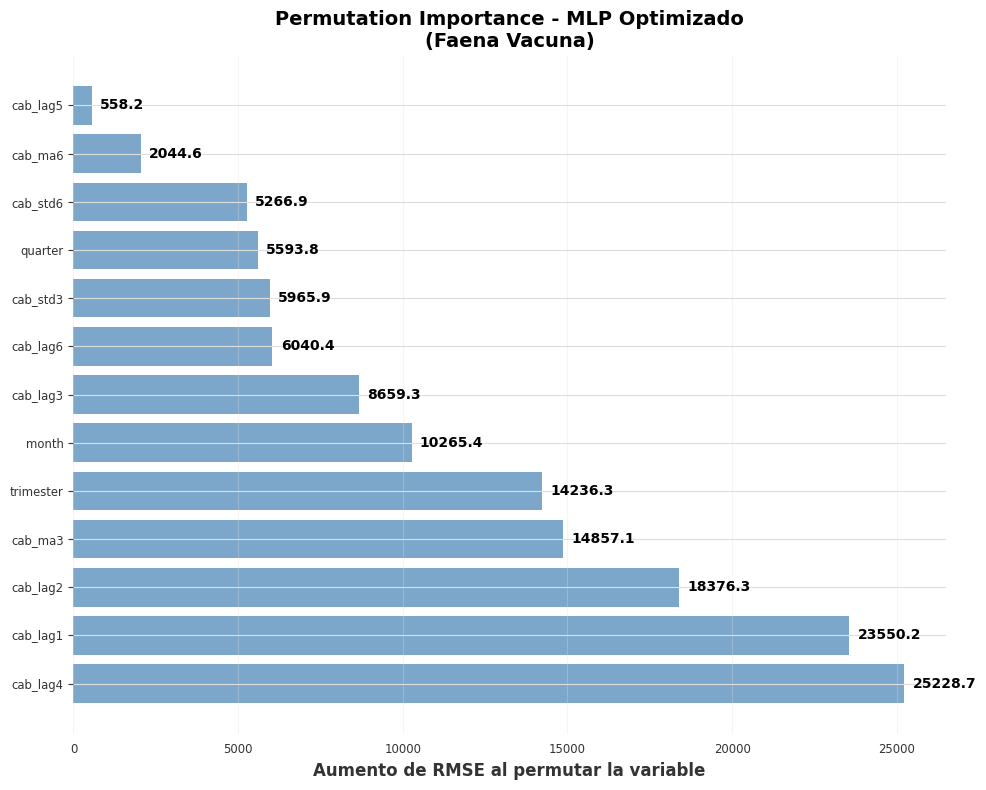


🔍 Top 5 variables más importantes:
  1. cab_lag4: +25228.75 RMSE
  2. cab_lag1: +23550.23 RMSE
  3. cab_lag2: +18376.26 RMSE
  4. cab_ma3: +14857.07 RMSE
  5. trimester: +14236.31 RMSE


In [74]:
# ==================== PERMUTATION IMPORTANCE ====================
print("\n" + "="*50)
print("ANÁLISIS DE IMPORTANCIA DE VARIABLES")
print("="*50)

print("Entrenando modelo final para análisis de importancia...")

# Entrenar modelo final con todos los datos
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(**best_mlp_params))
])

pipe_final.fit(X, y)

# Calcular RMSE base
y_pred_base = pipe_final.predict(X)
rmse_base = np.sqrt(mean_squared_error(y, y_pred_base))
print(f"RMSE base del modelo: {rmse_base:.2f}")

# Función para calcular permutation importance
def permute_rmse(col, n_repeat=5):
    rmse_scores = []
    X_perm = X.copy()
    
    for _ in range(n_repeat):
        X_perm[col] = np.random.permutation(X_perm[col].values)
        y_pred = pipe_final.predict(X_perm)
        rmse_perm = np.sqrt(mean_squared_error(y, y_pred))
        rmse_scores.append(rmse_perm)
    
    return np.mean(rmse_scores) - rmse_base

print("Calculando importancia de variables...")

# Calcular importancia para cada feature
importances = {}
for i, col in enumerate(features, 1):
    importance = permute_rmse(col, n_repeat=5)
    importances[col] = importance
    print(f"  {i:2d}/{len(features)} - {col}: +{importance:.2f}")

# Ordenar por importancia
importance_series = pd.Series(importances).sort_values(ascending=False)

# Gráfico de importancia
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_series)), importance_series.values, color='steelblue', alpha=0.7)
plt.yticks(range(len(importance_series)), importance_series.index)
plt.xlabel("Aumento de RMSE al permutar la variable", fontsize=12)
plt.title("Permutation Importance - MLP Optimizado\n(Faena Vacuna)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')

# Añadir valores en las barras
for i, v in enumerate(importance_series.values):
    plt.text(v + max(importance_series.values)*0.01, i, f'{v:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔍 Top 5 variables más importantes:")
for i, (var, imp) in enumerate(importance_series.head().items(), 1):
    print(f"  {i}. {var}: +{imp:.2f} RMSE")

In [75]:
# ==================== MLP PROFUNDO ====================
print("\n" + "="*60)
print("2.4 MLP PROFUNDO")
print("="*60)

rmse_scores_mlp_deep = []
mape_scores_mlp_deep = []
fold_preds_mlp_deep = []

# Parámetros para MLP profundo
deep_mlp_params = {
    'hidden_layer_sizes': (128, 64, 32, 16),  # 4 capas ocultas
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.001,
    'learning_rate_init': 0.001,
    'max_iter': 500,
    'early_stopping': True,
    'validation_fraction': 0.2,
    'n_iter_no_change': 20,
    'random_state': 123
}

print("Parámetros del MLP profundo:")
for k, v in deep_mlp_params.items():
    print(f"  {k}: {v}")

print(f"\nEntrenando MLP profundo...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar modelo
    deep_mlp_model = MLPRegressor(**deep_mlp_params)
    deep_mlp_model.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = deep_mlp_model.predict(X_test_s)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_mlp_deep.append(rmse_val)
    mape_scores_mlp_deep.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_mlp_deep.append(fold_df)

print(f"\n🔺 MLP Profundo - RMSE promedio: {np.mean(rmse_scores_mlp_deep):.2f}")
print(f"🔺 MLP Profundo - MAPE promedio: {np.mean(mape_scores_mlp_deep):.2f}%")


2.4 MLP PROFUNDO
Parámetros del MLP profundo:
  hidden_layer_sizes: (128, 64, 32, 16)
  activation: relu
  solver: adam
  alpha: 0.001
  learning_rate_init: 0.001
  max_iter: 500
  early_stopping: True
  validation_fraction: 0.2
  n_iter_no_change: 20
  random_state: 123

Entrenando MLP profundo...
  Fold 1 → RMSE = 386256.97, MAPE = 30.42%
  Fold 2 → RMSE = 380819.99, MAPE = 28.40%
  Fold 3 → RMSE = 361701.73, MAPE = 24.29%
  Fold 4 → RMSE = 224591.31, MAPE = 12.55%
  Fold 5 → RMSE = 343659.89, MAPE = 22.28%

🔺 MLP Profundo - RMSE promedio: 339405.98
🔺 MLP Profundo - MAPE promedio: 23.59%


In [76]:
# ==================== COMPARACIÓN FINAL DE MODELOS ANN ====================
print("\n" + "="*60)
print("2.5 COMPARACIÓN FINAL - MODELOS ARTIFICIAL NEURAL NETWORK")
print("="*60)

# Resumen de los 3 modelos ANN
results_ann_df = pd.DataFrame({
    'Modelo': ['MLP Básico', 'MLP Optimizado', 'MLP Profundo'],
    'RMSE_Promedio': [
        np.mean(rmse_scores_mlp_basic),
        np.mean(rmse_scores_mlp_optimized),
        np.mean(rmse_scores_mlp_deep)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_mlp_basic),
        np.mean(mape_scores_mlp_optimized),
        np.mean(mape_scores_mlp_deep)
    ]
})

print("📊 RESUMEN DE RESULTADOS:")
print(results_ann_df.round(2))

# Identificar el mejor modelo
best_ann_mape_idx = results_ann_df['MAPE_Promedio'].idxmin()
best_ann_rmse_idx = results_ann_df['RMSE_Promedio'].idxmin()

print(f"\n🏆 Mejor modelo por MAPE: {results_ann_df.loc[best_ann_mape_idx, 'Modelo']} ({results_ann_df.loc[best_ann_mape_idx, 'MAPE_Promedio']:.2f}%)")
print(f"🏆 Mejor modelo por RMSE: {results_ann_df.loc[best_ann_rmse_idx, 'Modelo']} ({results_ann_df.loc[best_ann_rmse_idx, 'RMSE_Promedio']:.2f})")

# Calcular mejoras
basic_rmse = results_ann_df.loc[0, 'RMSE_Promedio']
basic_mape = results_ann_df.loc[0, 'MAPE_Promedio']
optimized_rmse = results_ann_df.loc[1, 'RMSE_Promedio']
optimized_mape = results_ann_df.loc[1, 'MAPE_Promedio']

rmse_improvement = basic_rmse - optimized_rmse
mape_improvement = basic_mape - optimized_mape

print(f"\n📈 Mejoras de la optimización (vs modelo básico):")
print(f"  RMSE: {rmse_improvement:+.2f} ({rmse_improvement/basic_rmse*100:+.1f}%)")
print(f"  MAPE: {mape_improvement:+.2f}% ({mape_improvement/basic_mape*100:+.1f}%)")



2.5 COMPARACIÓN FINAL - MODELOS ARTIFICIAL NEURAL NETWORK
📊 RESUMEN DE RESULTADOS:
           Modelo  RMSE_Promedio  MAPE_Promedio
0      MLP Básico      898245.10          77.59
1  MLP Optimizado       84901.88           6.24
2    MLP Profundo      339405.98          23.59

🏆 Mejor modelo por MAPE: MLP Optimizado (6.24%)
🏆 Mejor modelo por RMSE: MLP Optimizado (84901.88)

📈 Mejoras de la optimización (vs modelo básico):
  RMSE: +813343.22 (+90.5%)
  MAPE: +71.34% (+92.0%)


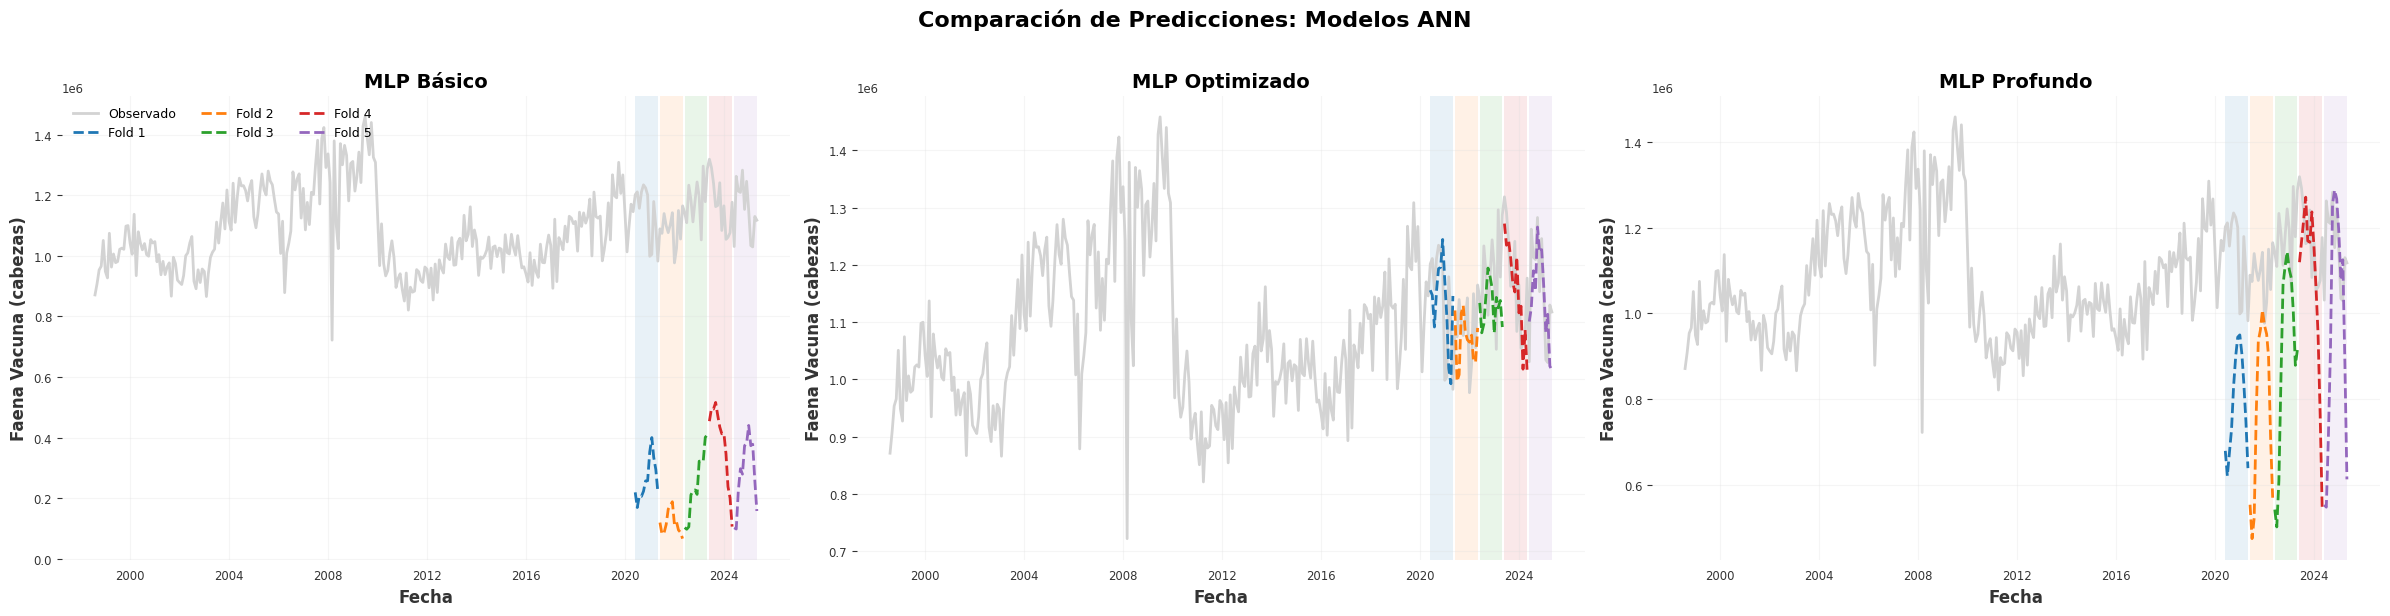

In [79]:
# ==================== GRÁFICOS FINALES ====================
# Predicciones de los 3 modelos ANN
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

models_ann_data = [
    ('MLP Básico', fold_preds_mlp_basic),
    ('MLP Optimizado', fold_preds_mlp_optimized),
    ('MLP Profundo', fold_preds_mlp_deep)
]

for idx, (model_name, fold_preds) in enumerate(models_ann_data):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(y.index, y.values, color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        idx_fold = fold_df.index
        ax.axvspan(idx_fold[0], idx_fold[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_fold, fold_df['y_pred'].values, color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Comparación de Predicciones: Modelos ANN', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

-----
> ### Modelos de Machine Learning

==================== MODELOS DE MACHINE LEARNING ====================

Los algoritmos de Machine Learning representan una evolución natural desde los métodos estadísticos tradicionales hacia enfoques más flexibles y potentes para el modelado de series temporales. A diferencia de los modelos paramétricos como ARIMA, estos métodos 
no asumen una estructura específica subyacente en los datos, sino que aprenden patrones complejos directamente desde las observaciones.

🌟 CARACTERÍSTICAS GENERALES:
• Capacidad de modelar relaciones NO LINEALES sin especificación previa
• Robustez ante outliers y cambios estructurales
• Manejo eficiente de múltiples variables explicativas simultáneamente
• Flexibilidad para capturar interacciones complejas entre features
• Menor dependencia de supuestos distribucionales

🌳 RANDOM FOREST:
Es un método de ensamblado que combina múltiples árboles de decisión para generar predicciones más robustas y precisas.

PRINCIPIO DE FUNCIONAMIENTO:
• Construye N árboles de decisión sobre muestras bootstrap de los datos
• Cada árbol usa un subconjunto aleatorio de variables en cada división
• La predicción final es el promedio de todos los árboles individuales
• Reduce overfitting mediante diversificación y votación

VENTAJAS ESPECÍFICAS:
• Maneja automáticamente interacciones entre variables
• Proporciona medidas de importancia de features nativas
• Robusto ante valores atípicos y datos faltantes
• No requiere escalado de variables
• Intervalos de confianza mediante distribución de predicciones de árboles

HIPERPARÁMETROS CLAVE:
• n_estimators: Número de árboles [50, 100, 200, 300]
• max_depth: Profundidad máxima [5, 10, 15, 20, None]
• min_samples_split/leaf: Control de overfitting [2, 5, 10] / [1, 2, 4]
• max_features: Variables por división ['sqrt', 'log2', 0.3, 0.5]

🚀 LIGHTGBM (LIGHT GRADIENT BOOSTING MACHINE):
Implementación optimizada de Gradient Boosting que construye modelos de manera secuencial, donde cada nuevo modelo corrige errores del anterior.

PRINCIPIO DE FUNCIONAMIENTO:
• Entrenamiento secuencial: cada árbol aprende de los errores previos
• Leaf-wise growth: crecimiento eficiente enfocado en reducir error
• Optimizaciones de memoria y velocidad para big data
• Regularización automática para prevenir overfitting

VENTAJAS ESPECÍFICAS:
• Velocidad de entrenamiento superior a XGBoost tradicional
• Manejo eficiente de variables categóricas
• Menor uso de memoria
• Early stopping automático
• Excelente rendimiento predictivo con pocos datos

HIPERPARÁMETROS CLAVE:
• num_leaves: Complejidad del modelo [25, 31, 40, 50]
• learning_rate: Velocidad de aprendizaje [0.08, 0.1, 0.12, 0.15]
• n_estimators: Número de iteraciones [80, 100, 120, 150]
• feature_fraction: Muestreo de variables [0.8]
• bagging_fraction: Muestreo de observaciones [0.8]

⚡ XGBOOST (EXTREME GRADIENT BOOSTING):
Algoritmo de boosting altamente optimizado que ha dominado competencias de machine learning por su precisión y robustez.

PRINCIPIO DE FUNCIONAMIENTO:
• Gradient boosting con regularización L1 y L2 incorporada
• Optimizaciones algorítmicas para velocidad y precisión
• Manejo automático de missing values
• Paralelización eficiente del entrenamiento

VENTAJAS ESPECÍFICAS:
• Excelente capacidad predictiva out-of-the-box
• Regularización incorporada previene overfitting
• Manejo robusto de datos faltantes
• Amplia adopción y documentación
• Interpretabilidad mediante SHAP values

HIPERPARÁMETROS CLAVE:
• n_estimators: Número de árboles [80, 100, 120, 150]
• max_depth: Profundidad [4, 5, 6, 8]
• learning_rate: Tasa de aprendizaje [0.08, 0.1, 0.12, 0.15]
• subsample: Muestreo de filas [0.8]
• colsample_bytree: Muestreo de columnas [0.8]
• reg_alpha/lambda: Regularización L1/L2 [0, 1]

🔧 FEATURE ENGINEERING UNIFICADO:
Todos los modelos utilizan el mismo conjunto de features engineeradas:

COMPONENTES AUTORREGRESIVOS:
• Lags 1-6: Capturan dependencia temporal directa
• Rolling means (3,6): Tendencias de corto/mediano plazo
• Rolling std (3,6): Volatilidad cambiante en el tiempo

COMPONENTES ESTACIONALES:
• Month (1-12): Estacionalidad mensual explícita
• Quarter (1-4): Patrones trimestrales
• Trimester (1-3): Ciclos específicos de 4 meses

Esta ingeniería permite que todos los modelos capturen simultáneamente:
- Autocorrelación temporal
- Patrones estacionales múltiples  
- Volatilidad variable
- Tendencias suavizadas

📊 ESTRATEGIA DE OPTIMIZACIÓN:
Los tres algoritmos siguen una metodología de optimización sistemática:

VALIDACIÓN TEMPORAL:
• TimeSeriesSplit (5 folds, 12 meses test): Respeta orden cronológico
• Evita data leakage del futuro al pasado
• Simula escenario real de predicción mes a mes

BÚSQUEDA DE HIPERPARÁMETROS:
• Random Forest: RandomizedSearchCV exhaustivo (20 iteraciones)
• LightGBM/XGBoost: Configuraciones preseleccionadas + validación rápida
• Optimización por MAPE: Enfoque en error porcentual relevante

MÉTRICAS DE EVALUACIÓN:
• RMSE: Error absoluto en unidades originales
• MAPE: Error porcentual para comparabilidad
• Feature Importance: Interpretabilidad del modelo

🎯 VENTAJAS COMPARATIVAS EN SERIES TEMPORALES:
• FLEXIBILIDAD: Modelan relaciones no lineales complejas sin especificación previa
• ROBUSTEZ: Menos sensibles a outliers que modelos paramétricos
• ESCALABILIDAD: Manejan múltiples variables explicativas eficientemente  
• INTERPRETABILIDAD: Feature importance nativa para entender drivers
• GENERALIZACIÓN: Ensemble methods reducen overfitting naturalmente

⚠️ CONSIDERACIONES:
• Menor interpretabilidad teórica vs modelos estadísticos
• Requieren feature engineering cuidadoso para series temporales
• Riesgo de overfitting sin validación temporal apropiada
• Mayor complejidad computacional que modelos lineales

🏆 IMPLEMENTACIÓN EN ESTE ANÁLISIS:
Para cada algoritmo se prueban dos versiones:
1. BÁSICO: Configuración por defecto para benchmark rápido
2. OPTIMIZADO: Hiperparámetros ajustados para máximo rendimiento

In [83]:
# ==================== 1 RANDOM FOREST BÁSICO ====================
print("="*60)
print("3.1 RANDOM FOREST BÁSICO")
print("="*60)

# Parámetros base para Random Forest
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': 123
}

print("Parámetros del Random Forest básico:")
for k, v in rf_params.items():
    print(f"  {k}: {v}")

# Validación cruzada para Random Forest básico
rmse_scores_rf_basic = []
mape_scores_rf_basic = []
fold_preds_rf_basic = []

print(f"\nEntrenando Random Forest básico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Random Forest no necesita escalado, pero podemos aplicarlo por consistencia
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Entrenar
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_s, y_train)
    
    # Predecir
    y_pred = rf.predict(X_test_s)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_rf_basic.append(rmse_val)
    mape_scores_rf_basic.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_rf_basic.append(fold_df)

print(f"\n🌳 Random Forest Básico - RMSE promedio: {np.mean(rmse_scores_rf_basic):.2f}")
print(f"🌳 Random Forest Básico - MAPE promedio: {np.mean(mape_scores_rf_basic):.2f}%")

3.1 RANDOM FOREST BÁSICO
Parámetros del Random Forest básico:
  n_estimators: 100
  max_depth: 10
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  bootstrap: True
  n_jobs: -1
  random_state: 123

Entrenando Random Forest básico...
  Fold 1 → RMSE = 80099.99, MAPE = 5.48%
  Fold 2 → RMSE = 57830.17, MAPE = 4.33%
  Fold 3 → RMSE = 74201.86, MAPE = 5.02%
  Fold 4 → RMSE = 75716.67, MAPE = 5.76%
  Fold 5 → RMSE = 61130.63, MAPE = 4.26%

🌳 Random Forest Básico - RMSE promedio: 69795.86
🌳 Random Forest Básico - MAPE promedio: 4.97%


In [86]:
print("\n" + "="*60)
print("3.2 LIGHTGBM BÁSICO")
print("="*60)

# Parámetros base para LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'n_estimators': 100,
    'random_state': 123,
    'verbose': -1
}

print("Parámetros del LightGBM básico:")
for k, v in lgb_params.items():
    print(f"  {k}: {v}")

# Validación cruzada para LightGBM básico
rmse_scores_lgb_basic = []
mape_scores_lgb_basic = []
fold_preds_lgb_basic = []

print(f"\nEntrenando LightGBM básico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar (CORREGIDO)
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]  # Silenciar output
    )
    
    # Predecir
    y_pred = lgb_model.predict(X_test)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_lgb_basic.append(rmse_val)
    mape_scores_lgb_basic.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_lgb_basic.append(fold_df)

print(f"\n🚀 LightGBM Básico - RMSE promedio: {np.mean(rmse_scores_lgb_basic):.2f}")
print(f"🚀 LightGBM Básico - MAPE promedio: {np.mean(mape_scores_lgb_basic):.2f}%")



3.2 LIGHTGBM BÁSICO
Parámetros del LightGBM básico:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.1
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  min_data_in_leaf: 20
  n_estimators: 100
  random_state: 123
  verbose: -1

Entrenando LightGBM básico...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 94079.2
  Fold 1 → RMSE = 94079.22, MAPE = 7.95%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 55201.4
  Fold 2 → RMSE = 55201.40, MAPE = 3.89%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's rmse: 70240.2
  Fold 3 → RMSE = 70240.18, MAPE = 5.13%
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 66304.8
  Fold 4 → RMSE = 66304.82, MAPE = 5.03%
Training unt

In [93]:
# ==================== 3.3 XGBOOST BÁSICO ====================
print("\n" + "="*60)
print("3.3 XGBOOST BÁSICO")
print("="*60)

# Parámetros base para XGBoost (SIN early stopping)
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 123,
    'verbosity': 0,
    'n_jobs': -1
}

print("Parámetros del XGBoost básico:")
for k, v in xgb_params.items():
    print(f"  {k}: {v}")

# Validación cruzada para XGBoost básico
rmse_scores_xgb_basic = []
mape_scores_xgb_basic = []
fold_preds_xgb_basic = []

print(f"\nEntrenando XGBoost básico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Entrenar (SIMPLIFICADO - sin eval_set)
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train)
    
    # Predecir
    y_pred = xgb_model.predict(X_test)
    
    # Métricas
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_xgb_basic.append(rmse_val)
    mape_scores_xgb_basic.append(mape_val)
    
    # Guardar para gráfico
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_xgb_basic.append(fold_df)

print(f"\n⚡ XGBoost Básico - RMSE promedio: {np.mean(rmse_scores_xgb_basic):.2f}")
print(f"⚡ XGBoost Básico - MAPE promedio: {np.mean(mape_scores_xgb_basic):.2f}%")



3.3 XGBOOST BÁSICO
Parámetros del XGBoost básico:
  n_estimators: 100
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1
  reg_alpha: 0
  reg_lambda: 1
  random_state: 123
  verbosity: 0
  n_jobs: -1

Entrenando XGBoost básico...
  Fold 1 → RMSE = 93141.51, MAPE = 6.63%
  Fold 2 → RMSE = 62329.86, MAPE = 4.96%
  Fold 3 → RMSE = 78415.38, MAPE = 5.28%
  Fold 4 → RMSE = 86747.10, MAPE = 6.01%
  Fold 5 → RMSE = 62671.51, MAPE = 4.19%

⚡ XGBoost Básico - RMSE promedio: 76661.07
⚡ XGBoost Básico - MAPE promedio: 5.41%


In [94]:
# ==================== OPTIMIZACIÓN DE HIPERPARÁMETROS ====================
print("\n" + "="*60)
print("3.4 OPTIMIZACIÓN DE HIPERPARÁMETROS - RANDOMIZED SEARCH")
print("="*60)

# Usar RandomizedSearchCV para ser más eficiente que GridSearch
print("Nota: Usando RandomizedSearchCV para mayor eficiencia con múltiples modelos...")


3.4 OPTIMIZACIÓN DE HIPERPARÁMETROS - RANDOMIZED SEARCH
Nota: Usando RandomizedSearchCV para mayor eficiencia con múltiples modelos...


In [95]:
# ==================== RANDOM FOREST OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO RANDOM FOREST")
print("="*50)

# Pipeline para Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=123))
])

# Parámetros para optimizar
param_dist_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.3, 0.5]
}

print("Optimizando Random Forest...")
random_search_rf = RandomizedSearchCV(
    pipe_rf, param_dist_rf, n_iter=20, cv=tscv, 
    scoring={'rmse': rmse_scorer, 'mape': mape_scorer},
    refit='mape', n_jobs=-1, verbose=1, random_state=123
)

random_search_rf.fit(X, y)

print("🏆 Mejores hiperparámetros Random Forest:")
for k, v in random_search_rf.best_params_.items():
    print(f"  {k}: {v}")


OPTIMIZANDO RANDOM FOREST
Optimizando Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🏆 Mejores hiperparámetros Random Forest:
  rf__n_estimators: 50
  rf__min_samples_split: 2
  rf__min_samples_leaf: 2
  rf__max_features: log2
  rf__max_depth: 15


In [97]:
# ==================== LIGHTGBM OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO LIGHTGBM")
print("="*50)

lgb_configs = [
    {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100},
    {'num_leaves': 50, 'learning_rate': 0.08, 'n_estimators': 150},
    {'num_leaves': 25, 'learning_rate': 0.15, 'n_estimators': 80},
    {'num_leaves': 40, 'learning_rate': 0.12, 'n_estimators': 120}
]

print("Probando configuraciones de LightGBM...")
best_lgb_score = float('inf')
best_lgb_params = None

for i, params in enumerate(lgb_configs, 1):
    params.update({
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'random_state': 123,
        'verbose': -1,
        'force_col_wise': True
    })
    
    # Validación cruzada rápida
    fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if fold_idx >= 3:  # Solo primeros 3 folds
            break
            
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_scores.append(safe_mape(y_test, y_pred))
    
    avg_score = np.mean(fold_scores)
    print(f"  Config {i}: MAPE = {avg_score:.2f}%")
    
    if avg_score < best_lgb_score:
        best_lgb_score = avg_score
        best_lgb_params = params

print(f"🏆 Mejor LightGBM: MAPE = {best_lgb_score:.2f}%")



OPTIMIZANDO LIGHTGBM
Probando configuraciones de LightGBM...
  Config 1: MAPE = 5.54%
  Config 2: MAPE = 5.64%
  Config 3: MAPE = 5.72%
  Config 4: MAPE = 5.96%
🏆 Mejor LightGBM: MAPE = 5.54%


In [98]:
# ==================== XGBOOST OPTIMIZADO ====================
print("\n" + "="*50)
print("OPTIMIZANDO XGBOOST")
print("="*50)

xgb_configs = [
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
    {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.08},
    {'n_estimators': 80, 'max_depth': 8, 'learning_rate': 0.15},
    {'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.12}
]

print("Probando configuraciones de XGBoost...")
best_xgb_score = float('inf')
best_xgb_params = None

for i, params in enumerate(xgb_configs, 1):
    params.update({
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 123,
        'verbosity': 0,
        'n_jobs': -1
    })
    
    # Validación cruzada rápida
    fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if fold_idx >= 3:  # Solo primeros 3 folds
            break
            
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_scores.append(safe_mape(y_test, y_pred))
    
    avg_score = np.mean(fold_scores)
    print(f"  Config {i}: MAPE = {avg_score:.2f}%")
    
    if avg_score < best_xgb_score:
        best_xgb_score = avg_score
        best_xgb_params = params

print(f"🏆 Mejor XGBoost: MAPE = {best_xgb_score:.2f}%")



OPTIMIZANDO XGBOOST
Probando configuraciones de XGBoost...
  Config 1: MAPE = 5.62%
  Config 2: MAPE = 5.21%
  Config 3: MAPE = 6.03%
  Config 4: MAPE = 5.82%
🏆 Mejor XGBoost: MAPE = 5.21%


In [101]:
# ==================== 3.5 MODELOS OPTIMIZADOS - VALIDACIÓN FINAL ====================
print("\n" + "="*60)
print("3.5 MODELOS OPTIMIZADOS - VALIDACIÓN FINAL")
print("="*60)


3.5 MODELOS OPTIMIZADOS - VALIDACIÓN FINAL


In [102]:
# ==================== RANDOM FOREST OPTIMIZADO ====================
print("\nEntrenando Random Forest Optimizado...")

# Extraer mejores parámetros
best_rf_params = {k.replace('rf__', ''): v for k, v in random_search_rf.best_params_.items() if k.startswith('rf__')}
best_rf_params['n_jobs'] = -1
best_rf_params['random_state'] = 123

print("Parámetros optimizados del Random Forest:")
for k, v in best_rf_params.items():
    print(f"  {k}: {v}")

rmse_scores_rf_opt = []
mape_scores_rf_opt = []
fold_preds_rf_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    rf_opt = RandomForestRegressor(**best_rf_params)
    rf_opt.fit(X_train_s, y_train)
    y_pred = rf_opt.predict(X_test_s)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_rf_opt.append(rmse_val)
    mape_scores_rf_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_rf_opt.append(fold_df)

print(f"\n🌳 Random Forest Optimizado - RMSE promedio: {np.mean(rmse_scores_rf_opt):.2f}")
print(f"🌳 Random Forest Optimizado - MAPE promedio: {np.mean(mape_scores_rf_opt):.2f}%")



Entrenando Random Forest Optimizado...
Parámetros optimizados del Random Forest:
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 2
  max_features: log2
  max_depth: 15
  n_jobs: -1
  random_state: 123
  Fold 1 → RMSE = 81077.59, MAPE = 5.51%
  Fold 2 → RMSE = 52848.87, MAPE = 4.00%
  Fold 3 → RMSE = 77262.27, MAPE = 5.11%
  Fold 4 → RMSE = 82737.52, MAPE = 6.17%
  Fold 5 → RMSE = 56494.23, MAPE = 3.87%

🌳 Random Forest Optimizado - RMSE promedio: 70084.10
🌳 Random Forest Optimizado - MAPE promedio: 4.93%


In [103]:
# ==================== LIGHTGBM OPTIMIZADO ====================
print("\nEntrenando LightGBM Optimizado...")

print("Parámetros optimizados del LightGBM:")
for k, v in best_lgb_params.items():
    if k not in ['objective', 'boosting_type', 'random_state', 'verbose', 'force_col_wise']:
        print(f"  {k}: {v}")

rmse_scores_lgb_opt = []
mape_scores_lgb_opt = []
fold_preds_lgb_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    lgb_opt = lgb.LGBMRegressor(**best_lgb_params)
    lgb_opt.fit(X_train, y_train)
    y_pred = lgb_opt.predict(X_test)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_lgb_opt.append(rmse_val)
    mape_scores_lgb_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_lgb_opt.append(fold_df)

print(f"\n🚀 LightGBM Optimizado - RMSE promedio: {np.mean(rmse_scores_lgb_opt):.2f}")
print(f"🚀 LightGBM Optimizado - MAPE promedio: {np.mean(mape_scores_lgb_opt):.2f}%")



Entrenando LightGBM Optimizado...
Parámetros optimizados del LightGBM:
  num_leaves: 31
  learning_rate: 0.1
  n_estimators: 100
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  min_data_in_leaf: 20
  Fold 1 → RMSE = 103466.97, MAPE = 7.78%
  Fold 2 → RMSE = 54518.55, MAPE = 3.72%
  Fold 3 → RMSE = 73570.49, MAPE = 5.13%
  Fold 4 → RMSE = 87623.11, MAPE = 5.97%
  Fold 5 → RMSE = 67522.65, MAPE = 4.80%

🚀 LightGBM Optimizado - RMSE promedio: 77340.35
🚀 LightGBM Optimizado - MAPE promedio: 5.48%


In [104]:
# ==================== XGBOOST OPTIMIZADO ====================
print("\nEntrenando XGBoost Optimizado...")

print("Parámetros optimizados del XGBoost:")
for k, v in best_xgb_params.items():
    if k not in ['random_state', 'verbosity', 'n_jobs']:
        print(f"  {k}: {v}")

rmse_scores_xgb_opt = []
mape_scores_xgb_opt = []
fold_preds_xgb_opt = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_opt = xgb.XGBRegressor(**best_xgb_params)
    xgb_opt.fit(X_train, y_train)
    y_pred = xgb_opt.predict(X_test)
    
    rmse_val = rmse(y_test, y_pred)
    mape_val = safe_mape(y_test, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_xgb_opt.append(rmse_val)
    mape_scores_xgb_opt.append(mape_val)
    
    idx_test = X.index[test_idx]
    fold_df = pd.DataFrame({
        'fold': fold,
        'y_true': y_test.values,
        'y_pred': y_pred
    }, index=idx_test)
    fold_preds_xgb_opt.append(fold_df)

print(f"\n⚡ XGBoost Optimizado - RMSE promedio: {np.mean(rmse_scores_xgb_opt):.2f}")
print(f"⚡ XGBoost Optimizado - MAPE promedio: {np.mean(mape_scores_xgb_opt):.2f}%")



Entrenando XGBoost Optimizado...
Parámetros optimizados del XGBoost:
  n_estimators: 150
  max_depth: 4
  learning_rate: 0.08
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1
  reg_alpha: 0
  reg_lambda: 1
  Fold 1 → RMSE = 98535.57, MAPE = 7.00%
  Fold 2 → RMSE = 51718.93, MAPE = 4.05%
  Fold 3 → RMSE = 68608.30, MAPE = 4.59%
  Fold 4 → RMSE = 94389.41, MAPE = 6.33%
  Fold 5 → RMSE = 57353.57, MAPE = 3.78%

⚡ XGBoost Optimizado - RMSE promedio: 74121.16
⚡ XGBoost Optimizado - MAPE promedio: 5.15%



3.6 ANÁLISIS DE FEATURE IMPORTANCE
Entrenando modelos finales para análisis de feature importance...


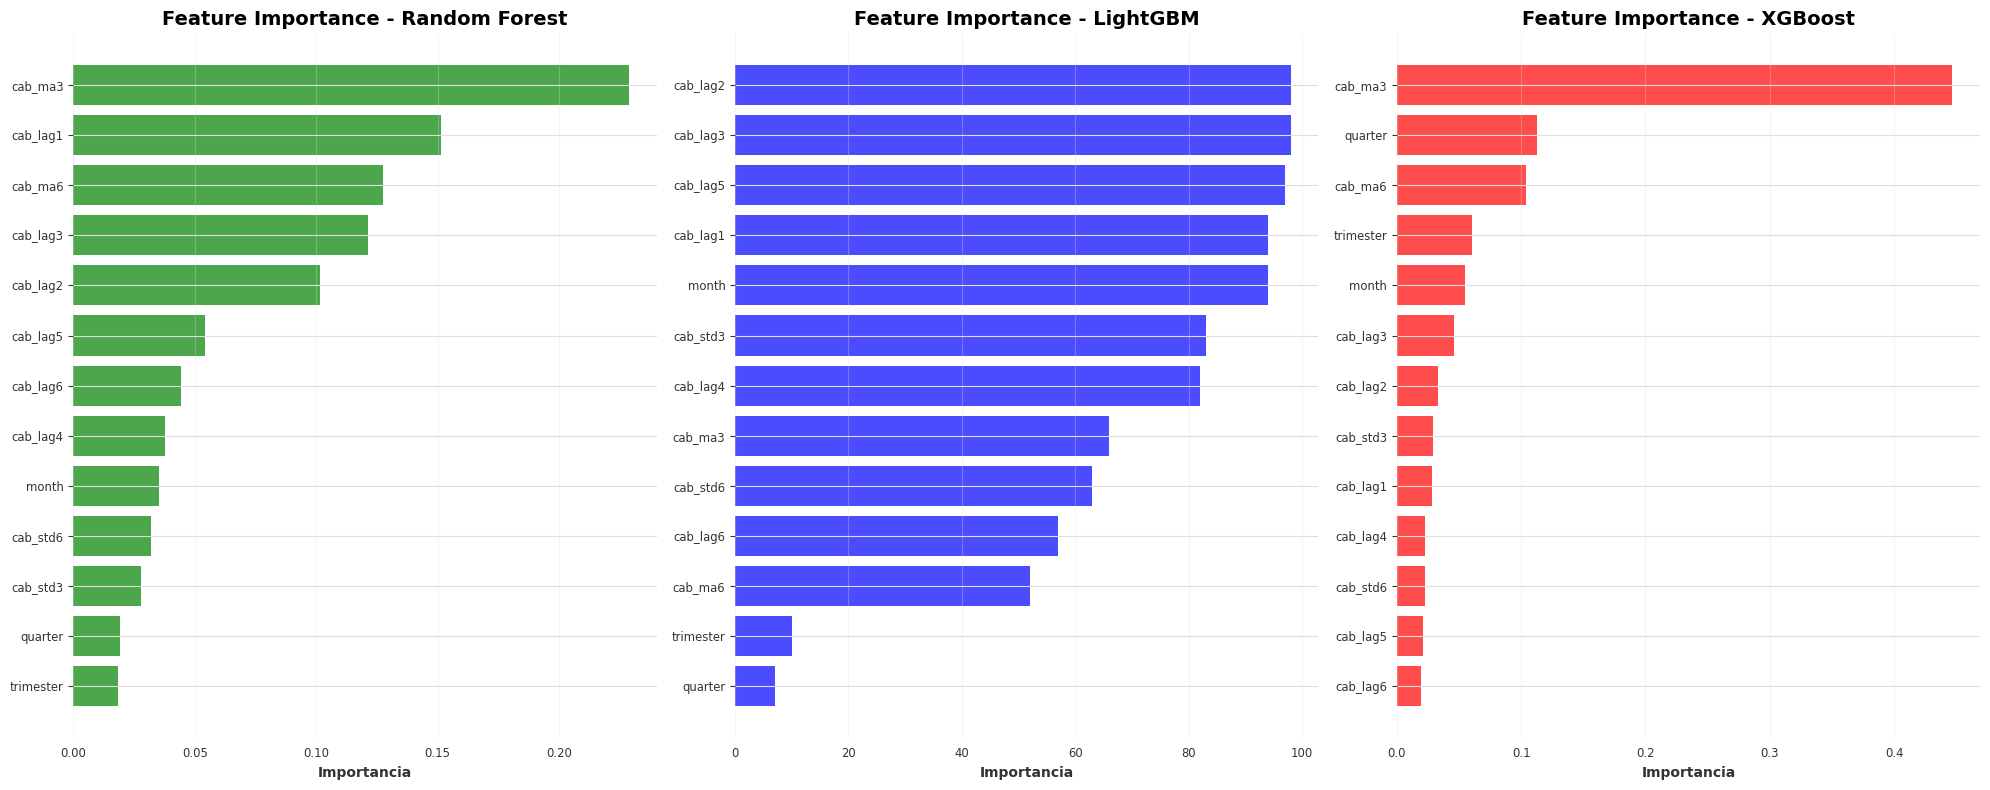

🔍 Top 5 variables más importantes por modelo:

Random Forest:
  1. cab_ma3: 0.229
  2. cab_lag1: 0.152
  3. cab_ma6: 0.128
  4. cab_lag3: 0.122
  5. cab_lag2: 0.102

LightGBM:
  1. cab_lag2: 98.000
  2. cab_lag3: 98.000
  3. cab_lag5: 97.000
  4. cab_lag1: 94.000
  5. month: 94.000

XGBoost:
  1. cab_ma3: 0.447
  2. quarter: 0.113
  3. cab_ma6: 0.104
  4. trimester: 0.060
  5. month: 0.055

📊 TOP 5 FEATURES MÁS IMPORTANTES (promedio entre modelos):
  1. cab_lag3: 32.722
  2. cab_lag2: 32.712
  3. cab_lag5: 32.358
  4. cab_lag1: 31.393
  5. month: 31.363


In [107]:
# ==================== 3.6 FEATURE IMPORTANCE ANÁLISIS ====================
print("\n" + "="*60)
print("3.6 ANÁLISIS DE FEATURE IMPORTANCE")
print("="*60)

print("Entrenando modelos finales para análisis de feature importance...")

# Random Forest Feature Importance
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

rf_final = RandomForestRegressor(**best_rf_params)
rf_final.fit(X_scaled, y)
rf_importance = pd.Series(rf_final.feature_importances_, index=features).sort_values(ascending=False)

# LightGBM Feature Importance
lgb_final = lgb.LGBMRegressor(**best_lgb_params)
lgb_final.fit(X, y)
lgb_importance = pd.Series(lgb_final.feature_importances_, index=features).sort_values(ascending=False)

# XGBoost Feature Importance
xgb_final = xgb.XGBRegressor(**best_xgb_params)
xgb_final.fit(X, y)
xgb_importance = pd.Series(xgb_final.feature_importances_, index=features).sort_values(ascending=False)

# Gráfico de Feature Importance
fig, axes = plt.subplots(1, 3, figsize=(20, 8))


# Random Forest
axes[0].barh(range(len(rf_importance)), rf_importance.values, color='green', alpha=0.7)
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance.index)
axes[0].set_title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Importancia')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# LightGBM
axes[1].barh(range(len(lgb_importance)), lgb_importance.values, color='blue', alpha=0.7)
axes[1].set_yticks(range(len(lgb_importance)))
axes[1].set_yticklabels(lgb_importance.index)
axes[1].set_title('Feature Importance - LightGBM', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Importancia')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

# XGBoost
axes[2].barh(range(len(xgb_importance)), xgb_importance.values, color='red', alpha=0.7)
axes[2].set_yticks(range(len(xgb_importance)))
axes[2].set_yticklabels(xgb_importance.index)
axes[2].set_title('Feature Importance - XGBoost', fontweight='bold', fontsize=14)
axes[2].set_xlabel('Importancia')
axes[2].invert_yaxis()
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Top 5 variables más importantes por modelo:")
print("\nRandom Forest:")
for i, (var, imp) in enumerate(rf_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

print("\nLightGBM:")
for i, (var, imp) in enumerate(lgb_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

print("\nXGBoost:")
for i, (var, imp) in enumerate(xgb_importance.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")

# Importancia promedio entre modelos
importance_df = pd.DataFrame({
    'Random_Forest': rf_importance,
    'LightGBM': lgb_importance,
    'XGBoost': xgb_importance
}).fillna(0)

importance_df['Promedio'] = importance_df.mean(axis=1)
importance_avg = importance_df['Promedio'].sort_values(ascending=False)

print(f"\n📊 TOP 5 FEATURES MÁS IMPORTANTES (promedio entre modelos):")
for i, (var, imp) in enumerate(importance_avg.head().items(), 1):
    print(f"  {i}. {var}: {imp:.3f}")


In [108]:
# ==================== COMPARACIÓN FINAL DE MODELOS ML ====================
print("\n" + "="*60)
print("3.7 COMPARACIÓN FINAL - MODELOS MACHINE LEARNING")
print("="*60)

# Resumen de todos los modelos ML (6 modelos)
results_ml_df = pd.DataFrame({
    'Modelo': [
        'RF Básico', 'RF Optimizado',
        'LightGBM Básico', 'LightGBM Optimizado',
        'XGBoost Básico', 'XGBoost Optimizado'
    ],
    'RMSE_Promedio': [
        np.mean(rmse_scores_rf_basic), np.mean(rmse_scores_rf_opt),
        np.mean(rmse_scores_lgb_basic), np.mean(rmse_scores_lgb_opt),
        np.mean(rmse_scores_xgb_basic), np.mean(rmse_scores_xgb_opt)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_rf_basic), np.mean(mape_scores_rf_opt),
        np.mean(mape_scores_lgb_basic), np.mean(mape_scores_lgb_opt),
        np.mean(rmse_scores_xgb_basic), np.mean(mape_scores_xgb_opt)
    ]
})

print("📊 RESUMEN DE RESULTADOS:")
print(results_ml_df.round(2))

# Identificar el mejor modelo
best_ml_mape_idx = results_ml_df['MAPE_Promedio'].idxmin()
best_ml_rmse_idx = results_ml_df['RMSE_Promedio'].idxmin()

print(f"\n🏆 Mejor modelo por MAPE: {results_ml_df.loc[best_ml_mape_idx, 'Modelo']} ({results_ml_df.loc[best_ml_mape_idx, 'MAPE_Promedio']:.2f}%)")
print(f"🏆 Mejor modelo por RMSE: {results_ml_df.loc[best_ml_rmse_idx, 'Modelo']} ({results_ml_df.loc[best_ml_rmse_idx, 'RMSE_Promedio']:.2f})")

# Calcular mejoras de optimización
rf_improvement = np.mean(rmse_scores_rf_basic) - np.mean(rmse_scores_rf_opt)
lgb_improvement = np.mean(rmse_scores_lgb_basic) - np.mean(rmse_scores_lgb_opt)
xgb_improvement = np.mean(rmse_scores_xgb_basic) - np.mean(rmse_scores_xgb_opt)

print(f"\n📈 Mejoras obtenidas con optimización (RMSE):")
print(f"  Random Forest: {rf_improvement:+.2f} ({rf_improvement/np.mean(rmse_scores_rf_basic)*100:+.1f}%)")
print(f"  LightGBM: {lgb_improvement:+.2f} ({lgb_improvement/np.mean(rmse_scores_lgb_basic)*100:+.1f}%)")
print(f"  XGBoost: {xgb_improvement:+.2f} ({xgb_improvement/np.mean(rmse_scores_xgb_basic)*100:+.1f}%)")



3.7 COMPARACIÓN FINAL - MODELOS MACHINE LEARNING
📊 RESUMEN DE RESULTADOS:
                Modelo  RMSE_Promedio  MAPE_Promedio
0            RF Básico       69795.86           4.97
1        RF Optimizado       70084.10           4.93
2      LightGBM Básico       69851.61           5.36
3  LightGBM Optimizado       77340.35           5.48
4       XGBoost Básico       76661.07       76661.07
5   XGBoost Optimizado       74121.16           5.15

🏆 Mejor modelo por MAPE: RF Optimizado (4.93%)
🏆 Mejor modelo por RMSE: RF Básico (69795.86)

📈 Mejoras obtenidas con optimización (RMSE):
  Random Forest: -288.23 (-0.4%)
  LightGBM: -7488.75 (-10.7%)
  XGBoost: +2539.92 (+3.3%)


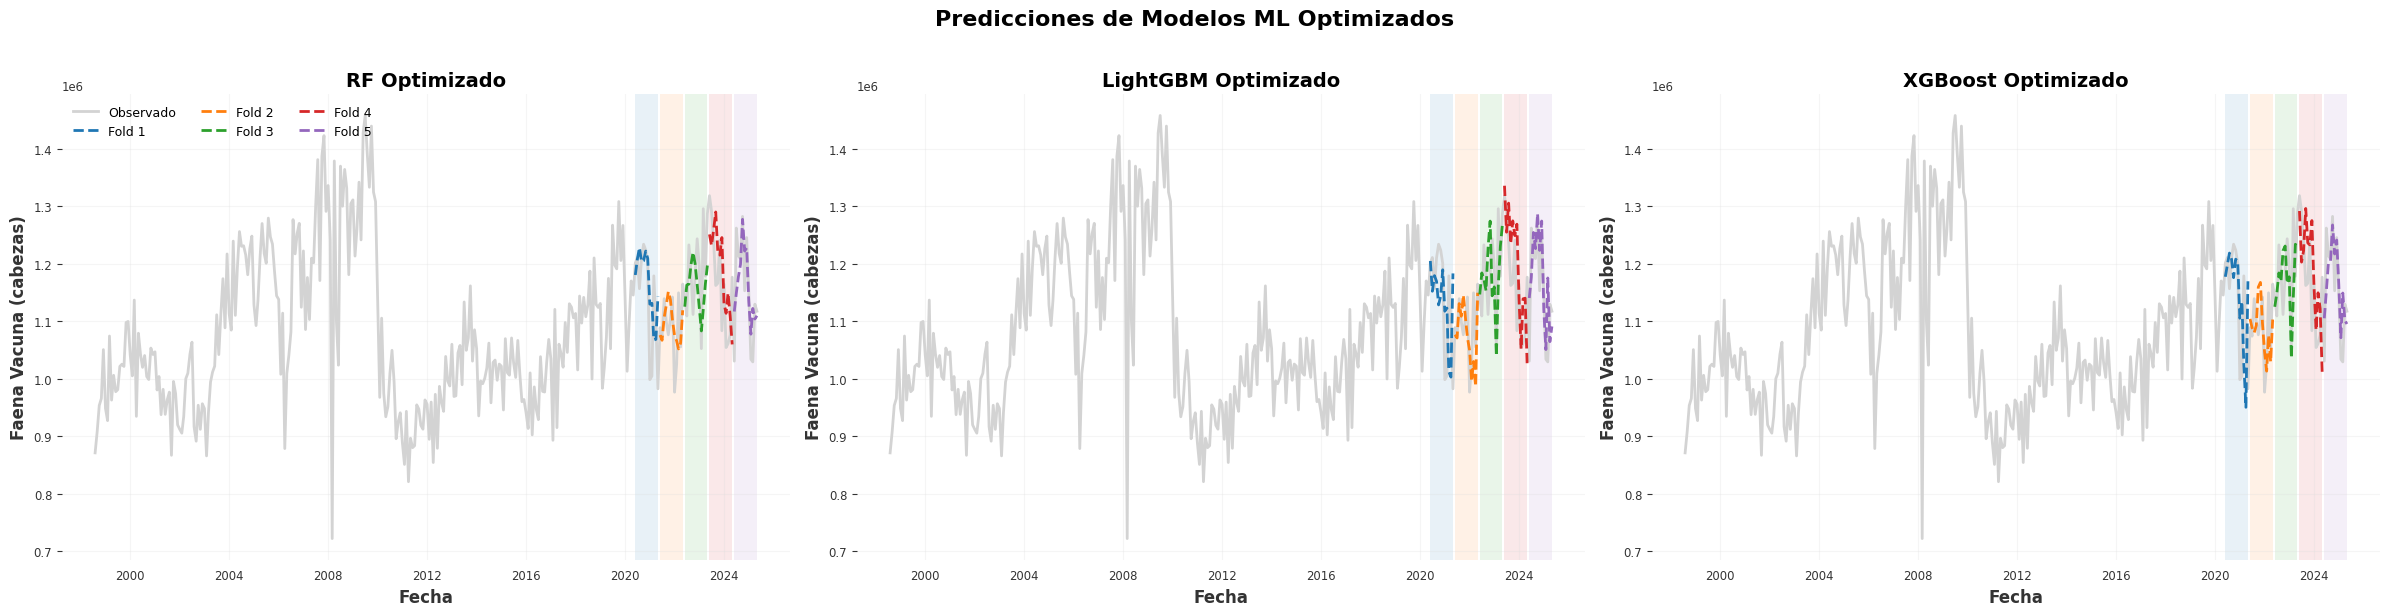

In [110]:
# ==================== GRÁFICOS FINALES ====================
# Predicciones de los mejores modelos
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

models_ml_data = [
    ('RF Optimizado', fold_preds_rf_opt),
    ('LightGBM Optimizado', fold_preds_lgb_opt),
    ('XGBoost Optimizado', fold_preds_xgb_opt)
]

for idx, (model_name, fold_preds) in enumerate(models_ml_data):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(y.index, y.values, color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        idx_fold = fold_df.index
        ax.axvspan(idx_fold[0], idx_fold[-1], facecolor=c, alpha=0.1)
        ax.plot(idx_fold, fold_df['y_pred'].values, color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}' if idx == 0 else '')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Predicciones de Modelos ML Optimizados', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

----
> ### Prophet

==================== FACEBOOK PROPHET ====================

Prophet es un algoritmo de forecasting desarrollado por Facebook (Meta) específicamente diseñado para series temporales de negocio con patrones estacionales fuertes y datos históricos de varios períodos. Representa un enfoque híbrido que combina la interpretabilidad de modelos estadísticos con la flexibilidad y robustez de métodos de machine learning.

🎯 FILOSOFÍA DE DISEÑO:
Prophet fue creado para ser "analyst-friendly", priorizando:
• Facilidad de uso para usuarios no expertos en estadística
• Robustez ante datos faltantes, outliers y cambios estructurales
• Interpretabilidad mediante descomposición de componentes
• Parámetros con significado intuitivo de negocio
• Manejo automático de festividades y eventos especiales

📊 MODELO MATEMÁTICO SUBYACENTE:
Prophet descompone una serie temporal y(t) como:
y(t) = g(t) + s(t) + h(t) + εₜ

Donde:
• g(t): TENDENCIA - Captura cambios no periódicos (crecimiento/decrecimiento)
• s(t): ESTACIONALIDAD - Patrones que se repiten en períodos fijos
• h(t): EFECTOS DE FESTIVIDADES - Impacto de eventos irregulares
• εₜ: RUIDO - Variación no explicada por los componentes anteriores

🚀 VENTAJAS ESPECÍFICAS PARA SERIES TEMPORALES:

ROBUSTEZ OPERACIONAL:
• Manejo automático de datos faltantes sin interpolación previa
• Resistencia a outliers mediante modelado robusto de errores
• Performance estable con diferentes frecuencias de datos
• Predicciones razonables incluso con datos limitados

FLEXIBILIDAD DE MODELADO:
• Detección automática de changepoints (cambios estructurales)
• Múltiples tipos de estacionalidad simultánea
• Incorporación natural de conocimiento de dominio (festividades)
• Intervalos de confianza mediante simulación de incertidumbre

INTERPRETABILIDAD:
• Descomposición visual clara de componentes
• Parámetros con significado de negocio directo
• Diagnósticos automáticos de calidad del modelo
• Identificación de drivers principales de la serie

🔧 HIPERPARÁMETROS Y OPTIMIZACIÓN:

PARÁMETROS DE TENDENCIA:
• changepoint_prior_scale [0.01, 0.05, 0.1, 0.5]: 
  Control de flexibilidad en detección de cambios estructurales
  - Valores bajos: Tendencia más suave, menos cambios
  - Valores altos: Mayor sensibilidad a cambios, riesgo de overfitting

• changepoint_range [0.8, 0.9]: 
  Proporción de datos históricos donde detectar changepoints
  - Evita cambios espurios al final de la serie

PARÁMETROS DE ESTACIONALIDAD:
• seasonality_mode ['additive', 'multiplicative']:
  - Additive: Efectos estacionales constantes en magnitud absoluta
  - Multiplicative: Efectos proporcionales al nivel de la serie

• seasonality_prior_scale [1, 5, 10, 15]:
  Control de flexibilidad estacional
  - Valores bajos: Patrones estacionales más suaves
  - Valores altos: Mayor adaptabilidad a variaciones estacionales

ESTACIONALIDADES PERSONALIZADAS:
• monthly_fourier_order [3, 5, 7]:
  Complejidad de patrones mensuales (número de armónicos de Fourier)
  - Mayor orden: Patrones más complejos, riesgo de overfitting
  - Menor orden: Patrones más suaves, posible underfitting

🔍 ESTRATEGIA DE OPTIMIZACIÓN IMPLEMENTADA:

GRID SEARCH EXHAUSTIVO:
• Espacio de búsqueda: 2×4×4×3×2 = 192 combinaciones totales
• Evaluación mediante TimeSeriesSplit (5 folds, 12 meses test)
• Métrica objetivo: MAPE (error porcentual promedio)
• Validación temporal estricta sin data leakage

PROCESO DE OPTIMIZACIÓN:
1. Generación sistemática de todas las combinaciones de hiperparámetros
2. Entrenamiento de modelo Prophet para cada combinación
3. Validación cruzada temporal con métricas RMSE y MAPE
4. Selección del modelo con menor MAPE promedio
5. Análisis de componentes del modelo óptimo

ROBUSTEZ DE LA BÚSQUEDA:
• Manejo de errores de convergencia
• Evaluación en múltiples folds temporales
• Registro completo de resultados para análisis posterior

⚠️ CONSIDERACIONES Y LIMITACIONES:

SUPUESTOS DEL MODELO:
• Asume descomposición aditiva/multiplicativa simple
• Componentes independientes (interacciones limitadas)
• Estacionalidad estable a lo largo del tiempo
• Changepoints como cambios abruptos vs graduales

REQUERIMIENTOS DE DATOS:
• Prefiere series con múltiples períodos completos
• Performance óptima con frecuencia regular (mensual, diaria)
• Beneficio marginal decreciente con datos muy largos
• Sensibilidad a calidad de datos en extremos de la serie

LIMITACIONES TÉCNICAS:
• Menor flexibilidad que modelos de ML puros
• Dificultad con patrones estacionales muy irregulares
• Interpretación limitada de interacciones complejas
• Dependencia de especificación correcta de festividades

🎯 IMPLEMENTACIÓN EN ESTE ANÁLISIS:

CONFIGURACIÓN BÁSICA:
• yearly_seasonality=True: Activación de patrones anuales
• weekly/daily_seasonality=False: Irrelevante para datos mensuales
• seasonality_mode='additive': Punto de partida conservador
• interval_width=0.95: Intervalos de confianza estándar

CONFIGURACIÓN OPTIMIZADA:
• Hiperparámetros ajustados mediante grid search exhaustivo
• Estacionalidad mensual personalizada incorporada
• Modo estacional optimizado (additive vs multiplicative)
• Parámetros de regularización calibrados para evitar overfitting

In [114]:
# ==================== PREPARACIÓN DE DATOS ====================
print("="*60)
print("4.1 PREPARACIÓN DE DATOS PARA PROPHET")
print("="*60)

# Preparar datos para Prophet (requiere columnas 'ds' y 'y')
df_prophet = df_faena.reset_index().copy()
df_prophet.rename(columns={'indice_tiempo': 'ds', 'vacunos_cabezas': 'y'}, inplace=True)

# Limpieza y validación de datos
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

# Eliminar valores nulos y duplicados
df_prophet = df_prophet.dropna(subset=['ds', 'y'])
df_prophet = df_prophet.sort_values('ds')
df_prophet = df_prophet[~df_prophet['ds'].duplicated()].reset_index(drop=True)

print(f"Dataset para Prophet:")
print(f"  Observaciones: {len(df_prophet)}")
print(f"  Rango temporal: {df_prophet['ds'].min().strftime('%Y-%m')} a {df_prophet['ds'].max().strftime('%Y-%m')}")
print(f"  Columnas: {df_prophet.columns.tolist()}")

# Mostrar estadísticas
print(f"\nEstadísticas de la variable objetivo:")
print(df_prophet['y'].describe().round(2))

# Verificar datos
print(f"\nCalidad de datos:")
print(f"  Valores nulos: {df_prophet.isnull().sum().sum()}")
print(f"  Fechas duplicadas: {df_prophet['ds'].duplicated().sum()}")

4.1 PREPARACIÓN DE DATOS PARA PROPHET
Dataset para Prophet:
  Observaciones: 328
  Rango temporal: 1998-02 a 2025-05
  Columnas: ['ds', 'y']

Estadísticas de la variable objetivo:
count        328.00
mean     1083363.21
std       131660.26
min       722024.00
25%       983365.88
50%      1061730.16
75%      1178836.44
max      1458327.25
Name: y, dtype: float64

Calidad de datos:
  Valores nulos: 0
  Fechas duplicadas: 0


In [115]:
# ==================== MODELO PROPHET BÁSICO ====================
print("\n" + "="*60)
print("4.2 MODELO PROPHET BÁSICO")
print("="*60)

# Parámetros base para Prophet (SIN variables exógenas)
prophet_params_basic = {
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'seasonality_mode': 'additive',
    'interval_width': 0.95
}

print("Parámetros del Prophet básico:")
for k, v in prophet_params_basic.items():
    print(f"  {k}: {v}")

# Configuración de validación cruzada
tscv = TimeSeriesSplit(n_splits=5, test_size=12)
colors = plt.get_cmap('tab10').colors

# Validación cruzada manual para Prophet básico
rmse_scores_prophet_basic = []
mape_scores_prophet_basic = []
fold_preds_prophet_basic = []

print(f"\nEntrenando Prophet básico...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet), start=1):
    # Dividir datos
    train_df = df_prophet.iloc[train_idx].copy()
    test_df = df_prophet.iloc[test_idx].copy()
    
    # Crear y entrenar modelo Prophet
    model = Prophet(**prophet_params_basic)
    model.fit(train_df)
    
    # Hacer pronósticos
    future = test_df[['ds']].copy()
    forecast = model.predict(future)
    
    # Extraer predicciones
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    
    # Métricas
    rmse_val = rmse(y_true, y_pred)
    mape_val = safe_mape(y_true, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_prophet_basic.append(rmse_val)
    mape_scores_prophet_basic.append(mape_val)
    
    # Guardar para gráfico
    fold_df = pd.DataFrame({
        'fold': fold,
        'ds': test_df['ds'].values,
        'y_true': y_true,
        'y_pred': y_pred
    })
    fold_preds_prophet_basic.append(fold_df)

print(f"\n📈 Prophet Básico - RMSE promedio: {np.mean(rmse_scores_prophet_basic):.2f}")
print(f"📈 Prophet Básico - MAPE promedio: {np.mean(mape_scores_prophet_basic):.2f}%")

16:23:40 - cmdstanpy - INFO - Chain [1] start processing



4.2 MODELO PROPHET BÁSICO
Parámetros del Prophet básico:
  yearly_seasonality: True
  weekly_seasonality: False
  daily_seasonality: False
  seasonality_mode: additive
  interval_width: 0.95

Entrenando Prophet básico...


16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing


  Fold 1 → RMSE = 82481.19, MAPE = 6.25%
  Fold 2 → RMSE = 87848.60, MAPE = 6.89%
  Fold 3 → RMSE = 78076.35, MAPE = 5.37%


16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing


  Fold 4 → RMSE = 80671.67, MAPE = 5.53%
  Fold 5 → RMSE = 74257.54, MAPE = 5.38%

📈 Prophet Básico - RMSE promedio: 80667.07
📈 Prophet Básico - MAPE promedio: 5.88%


In [116]:
# ==================== OPTIMIZACIÓN DE HIPERPARÁMETROS ====================
print("\n" + "="*60)
print("4.3 OPTIMIZACIÓN DE HIPERPARÁMETROS - GRID SEARCH")
print("="*60)

# Espacio de búsqueda para hiperparámetros
param_grid_prophet = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [1, 5, 10, 15],
    'monthly_fourier_order': [3, 5, 7],
    'changepoint_range': [0.8, 0.9],
}

# Función para generar todas las combinaciones
def product_dict(d):
    keys = d.keys()
    for values in itertools.product(*d.values()):
        yield dict(zip(keys, values))

# Función de evaluación
def evaluate_prophet_params(params, df_data):
    rmse_scores = []
    mape_scores = []
    
    for train_idx, test_idx in tscv.split(df_data):
        train_df = df_data.iloc[train_idx].copy()
        test_df = df_data.iloc[test_idx].copy()
        
        try:
            # Crear modelo con parámetros específicos
            model = Prophet(
                yearly_seasonality=True,  # Fijo
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode=params['seasonality_mode'],
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                changepoint_range=params['changepoint_range'],
                interval_width=0.95
            )
            
            # Agregar estacionalidad mensual personalizada
            model.add_seasonality(
                name='monthly',
                period=30.5,
                fourier_order=params['monthly_fourier_order']
            )
            
            # Entrenar
            model.fit(train_df)
            
            # Predecir
            future = test_df[['ds']].copy()
            forecast = model.predict(future)
            
            y_true = test_df['y'].values
            y_pred = forecast['yhat'].values
            
            # Métricas
            rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
            mape_val = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            
            rmse_scores.append(rmse_val)
            mape_scores.append(mape_val)
            
        except Exception as e:
            print(f"Error en fold: {e}")
            return np.inf, np.inf, np.inf, np.inf
    
    return np.mean(rmse_scores), np.std(rmse_scores), np.mean(mape_scores), np.std(mape_scores)

# Grid Search
print("Ejecutando Grid Search para Prophet...")
print(f"Combinaciones totales a evaluar: {np.prod([len(v) for v in param_grid_prophet.values()])}")

results_prophet = []
total_combinations = np.prod([len(v) for v in param_grid_prophet.values()])

for i, combo in enumerate(product_dict(param_grid_prophet), 1):
    print(f"Evaluando combinación {i}/{total_combinations}: {combo}")
    
    mean_rmse, std_rmse, mean_mape, std_mape = evaluate_prophet_params(combo, df_prophet)
    
    row = {
        **combo,
        'rmse_mean': round(mean_rmse, 4),
        'rmse_std': round(std_rmse, 4),
        'mape_mean': round(mean_mape, 4),
        'mape_std': round(std_mape, 4),
    }
    results_prophet.append(row)
    
    if i % 5 == 0:  # Mostrar progreso cada 5 iteraciones
        print(f"  → RMSE: {mean_rmse:.2f}, MAPE: {mean_mape:.2f}%")

# Crear DataFrame con resultados
results_prophet_df = pd.DataFrame(results_prophet).sort_values('mape_mean', ascending=True).reset_index(drop=True)

print("\n🏆 Top 10 combinaciones por MAPE promedio:")
print(results_prophet_df.head(10).round(3))

# Mejores parámetros
best_prophet_params = results_prophet_df.iloc[0].to_dict()

print("\n🎯 Mejores hiperparámetros encontrados:")
for k in param_grid_prophet.keys():
    print(f"  {k}: {best_prophet_params[k]}")
print(f"\n📊 Mejores métricas:")
print(f"  RMSE promedio: {best_prophet_params['rmse_mean']}")
print(f"  MAPE promedio: {best_prophet_params['mape_mean']:.2f}%")

16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing



4.3 OPTIMIZACIÓN DE HIPERPARÁMETROS - GRID SEARCH
Ejecutando Grid Search para Prophet...
Combinaciones totales a evaluar: 192
Evaluando combinación 1/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 2/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 3/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 4/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 5/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 98346.34, MAPE: 6.75%
Evaluando combinación 6/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 7/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 8/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 9/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 10/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 85755.37, MAPE: 6.16%
Evaluando combinación 11/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 12/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 13/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 14/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 15/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 85253.29, MAPE: 6.11%
Evaluando combinación 16/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 17/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 18/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 19/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 20/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 90041.23, MAPE: 6.19%
Evaluando combinación 21/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 22/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 23/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:03 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 24/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 25/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 100268.35, MAPE: 6.73%
Evaluando combinación 26/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:04 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 27/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 28/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:05 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 29/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 30/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 133048.69, MAPE: 8.70%
Evaluando combinación 31/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:06 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 32/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 33/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:07 - cmdstanpy - INFO - Chain [1] done processing
16:24:07 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 34/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 35/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:08 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 129257.76, MAPE: 8.54%
Evaluando combinación 36/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 37/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 38/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:09 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 39/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 40/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:10 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 106637.15, MAPE: 7.29%
Evaluando combinación 41/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 42/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 43/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 44/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 45/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 112100.58, MAPE: 7.62%
Evaluando combinación 46/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 47/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 48/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 49/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 50/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 99790.04, MAPE: 6.84%
Evaluando combinación 51/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 52/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 53/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 54/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 55/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 97653.85, MAPE: 6.68%
Evaluando combinación 56/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 57/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 58/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 59/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 60/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 124846.45, MAPE: 8.28%
Evaluando combinación 61/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 62/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 63/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 64/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 65/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 121840.28, MAPE: 7.99%
Evaluando combinación 66/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 67/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 68/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 69/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 70/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 112240.80, MAPE: 7.60%
Evaluando combinación 71/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 72/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 73/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 74/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 75/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 104580.49, MAPE: 7.34%
Evaluando combinación 76/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 77/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 78/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 79/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 80/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 93607.54, MAPE: 6.80%
Evaluando combinación 81/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 82/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 83/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 84/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 85/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 92285.01, MAPE: 6.40%
Evaluando combinación 86/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 87/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 88/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 89/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 90/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 114999.84, MAPE: 8.06%
Evaluando combinación 91/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 92/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 93/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 94/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 95/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 100618.58, MAPE: 7.13%
Evaluando combinación 96/192: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 97/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 98/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 99/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 100/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 84375.03, MAPE: 5.89%
Evaluando combinación 101/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 102/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 103/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 104/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 105/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 84006.90, MAPE: 5.86%
Evaluando combinación 106/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 107/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 108/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 109/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 110/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 94931.36, MAPE: 6.56%
Evaluando combinación 111/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 112/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 113/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 114/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 115/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 99373.63, MAPE: 6.81%
Evaluando combinación 116/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 117/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 118/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 119/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 120/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 94917.69, MAPE: 6.70%
Evaluando combinación 121/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 122/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 123/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 124/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 125/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 152738.38, MAPE: 9.75%
Evaluando combinación 126/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 127/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 128/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 129/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 130/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 115709.53, MAPE: 7.86%
Evaluando combinación 131/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 132/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 133/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 134/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 135/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 119818.28, MAPE: 8.16%
Evaluando combinación 136/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 137/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 138/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 139/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 140/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 110154.80, MAPE: 7.38%
Evaluando combinación 141/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 142/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 143/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 144/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 145/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 104391.97, MAPE: 7.06%
Evaluando combinación 146/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 147/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 148/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 149/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 150/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 142646.07, MAPE: 9.18%
Evaluando combinación 151/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 152/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 153/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 154/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 155/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 144661.35, MAPE: 9.27%
Evaluando combinación 156/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 157/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 158/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 159/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 160/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 111311.24, MAPE: 7.68%
Evaluando combinación 161/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 162/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 163/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 164/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 165/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 112781.77, MAPE: 7.77%
Evaluando combinación 166/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 167/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 168/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 169/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 170/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 105410.87, MAPE: 7.47%
Evaluando combinación 171/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 172/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 173/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 174/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 175/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 103126.24, MAPE: 6.89%
Evaluando combinación 176/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 177/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 178/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 179/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 180/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing


  → RMSE: 158431.37, MAPE: 10.12%
Evaluando combinación 181/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 182/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 183/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 184/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 185/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 140975.98, MAPE: 9.27%
Evaluando combinación 186/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 187/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.8}


16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 188/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 3, 'changepoint_range': 0.9}


16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 189/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.8}


16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluando combinación 190/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 5, 'changepoint_range': 0.9}


16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing


  → RMSE: 182727.06, MAPE: 11.03%
Evaluando combinación 191/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.8}


16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing


Evaluando combinación 192/192: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 15, 'monthly_fourier_order': 7, 'changepoint_range': 0.9}


16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing



🏆 Top 10 combinaciones por MAPE promedio:
  seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0         additive                     0.50                        1   
1   multiplicative                     0.01                        5   
2   multiplicative                     0.01                       10   
3   multiplicative                     0.01                       15   
4   multiplicative                     0.01                        1   
5   multiplicative                     0.01                        1   
6   multiplicative                     0.01                       10   
7   multiplicative                     0.01                       15   
8   multiplicative                     0.01                        5   
9         additive                     0.01                        5   

   monthly_fourier_order  changepoint_range  rmse_mean   rmse_std  mape_mean  \
0                      7                0.8  81906.026  17725.410      5.708   
1   

In [117]:
# ==================== MODELO PROPHET OPTIMIZADO ====================
print("\n" + "="*60)
print("4.4 MODELO PROPHET OPTIMIZADO - VALIDACIÓN FINAL")
print("="*60)

# Extraer mejores parámetros para entrenamiento
best_params_clean = {
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': False,
    'seasonality_mode': best_prophet_params['seasonality_mode'],
    'changepoint_prior_scale': best_prophet_params['changepoint_prior_scale'],
    'seasonality_prior_scale': best_prophet_params['seasonality_prior_scale'],
    'changepoint_range': best_prophet_params['changepoint_range'],
    'interval_width': 0.95
}

print("Parámetros del Prophet optimizado:")
for k, v in best_params_clean.items():
    print(f"  {k}: {v}")
print(f"  monthly_fourier_order: {best_prophet_params['monthly_fourier_order']}")

# Validación final con mejores parámetros
rmse_scores_prophet_opt = []
mape_scores_prophet_opt = []
fold_preds_prophet_opt = []

print(f"\nEntrenando Prophet optimizado...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_prophet), start=1):
    train_df = df_prophet.iloc[train_idx].copy()
    test_df = df_prophet.iloc[test_idx].copy()
    
    # Crear modelo optimizado
    model_opt = Prophet(**best_params_clean)
    model_opt.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=best_prophet_params['monthly_fourier_order']
    )
    
    # Entrenar
    model_opt.fit(train_df)
    
    # Predecir
    future = test_df[['ds']].copy()
    forecast = model_opt.predict(future)
    
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    
    # Métricas
    rmse_val = rmse(y_true, y_pred)
    mape_val = safe_mape(y_true, y_pred)
    
    print(f"  Fold {fold} → RMSE = {rmse_val:.2f}, MAPE = {mape_val:.2f}%")
    
    rmse_scores_prophet_opt.append(rmse_val)
    mape_scores_prophet_opt.append(mape_val)
    
    # Guardar para gráfico
    fold_df = pd.DataFrame({
        'fold': fold,
        'ds': test_df['ds'].values,
        'y_true': y_true,
        'y_pred': y_pred
    })
    fold_preds_prophet_opt.append(fold_df)

print(f"\n📈 Prophet Optimizado - RMSE promedio: {np.mean(rmse_scores_prophet_opt):.2f}")
print(f"📈 Prophet Optimizado - MAPE promedio: {np.mean(mape_scores_prophet_opt):.2f}%")

16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing



4.4 MODELO PROPHET OPTIMIZADO - VALIDACIÓN FINAL
Parámetros del Prophet optimizado:
  yearly_seasonality: True
  weekly_seasonality: False
  daily_seasonality: False
  seasonality_mode: additive
  changepoint_prior_scale: 0.5
  seasonality_prior_scale: 1
  changepoint_range: 0.8
  interval_width: 0.95
  monthly_fourier_order: 7

Entrenando Prophet optimizado...
  Fold 1 → RMSE = 96517.74, MAPE = 6.28%


16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing


  Fold 2 → RMSE = 83095.20, MAPE = 6.44%
  Fold 3 → RMSE = 78036.06, MAPE = 5.75%


16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing


  Fold 4 → RMSE = 101138.63, MAPE = 6.90%
  Fold 5 → RMSE = 50742.50, MAPE = 3.17%

📈 Prophet Optimizado - RMSE promedio: 81906.03
📈 Prophet Optimizado - MAPE promedio: 5.71%


16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing



4.5 ANÁLISIS DE COMPONENTES DE PROPHET
Entrenando modelo final para análisis de componentes...


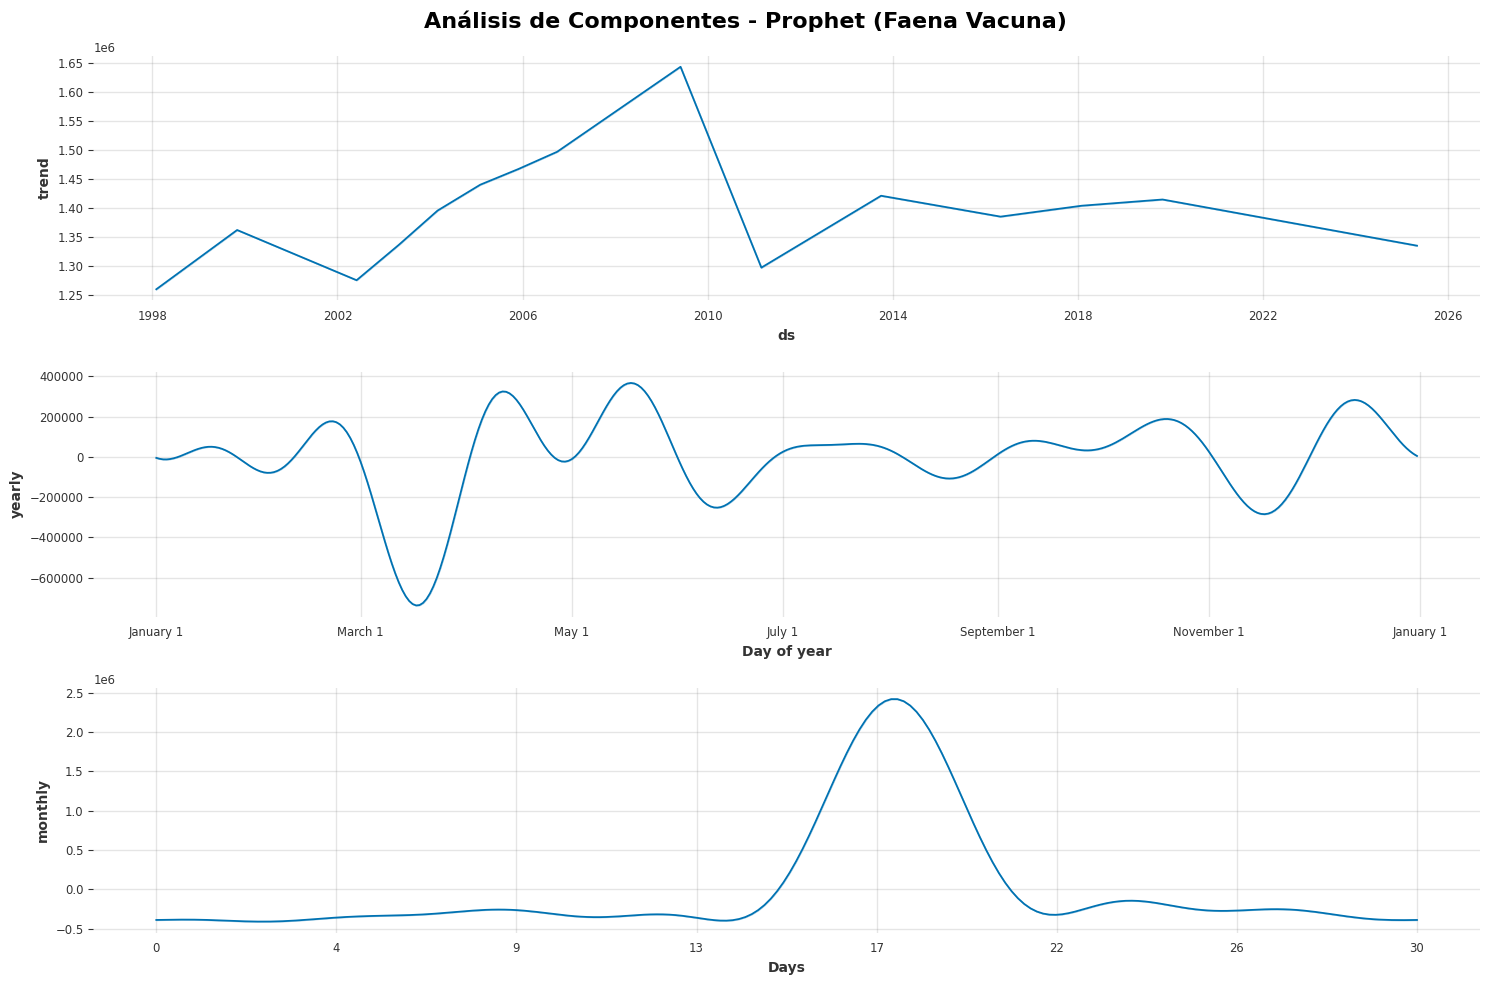

In [118]:
# ==================== ANÁLISIS DE COMPONENTES ====================
print("\n" + "="*60)
print("4.5 ANÁLISIS DE COMPONENTES DE PROPHET")
print("="*60)

# Entrenar modelo final para análisis de componentes
print("Entrenando modelo final para análisis de componentes...")

final_prophet = Prophet(**best_params_clean)
final_prophet.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=best_prophet_params['monthly_fourier_order']
)

final_prophet.fit(df_prophet)

# Crear futuro para toda la serie
future_full = final_prophet.make_future_dataframe(periods=0, freq='MS')
forecast_full = final_prophet.predict(future_full)

# Gráfico de componentes
fig = final_prophet.plot_components(forecast_full, figsize=(15, 10))
plt.suptitle('Análisis de Componentes - Prophet (Faena Vacuna)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [119]:
# ==================== COMPARACIÓN PROPHET: BÁSICO VS OPTIMIZADO ====================
print("\n" + "="*60)
print("4.6 COMPARACIÓN FINAL - PROPHET")
print("="*60)

# Resumen de modelos Prophet
results_prophet_comparison = pd.DataFrame({
    'Modelo': ['Prophet Básico', 'Prophet Optimizado'],
    'RMSE_Promedio': [
        np.mean(rmse_scores_prophet_basic),
        np.mean(rmse_scores_prophet_opt)
    ],
    'MAPE_Promedio': [
        np.mean(mape_scores_prophet_basic),
        np.mean(mape_scores_prophet_opt)
    ]
})

print("📊 RESUMEN DE RESULTADOS PROPHET:")
print(results_prophet_comparison.round(2))

# Calcular mejora
rmse_improvement = np.mean(rmse_scores_prophet_basic) - np.mean(rmse_scores_prophet_opt)
mape_improvement = np.mean(mape_scores_prophet_basic) - np.mean(mape_scores_prophet_opt)

print(f"\n📈 Mejoras obtenidas con optimización:")
print(f"  RMSE: {rmse_improvement:+.2f} ({rmse_improvement/np.mean(rmse_scores_prophet_basic)*100:+.1f}%)")
print(f"  MAPE: {mape_improvement:+.2f}% ({mape_improvement/np.mean(mape_scores_prophet_basic)*100:+.1f}%)")


4.6 COMPARACIÓN FINAL - PROPHET
📊 RESUMEN DE RESULTADOS PROPHET:
               Modelo  RMSE_Promedio  MAPE_Promedio
0      Prophet Básico       80667.07           5.88
1  Prophet Optimizado       81906.03           5.71

📈 Mejoras obtenidas con optimización:
  RMSE: -1238.95 (-1.5%)
  MAPE: +0.18% (+3.0%)


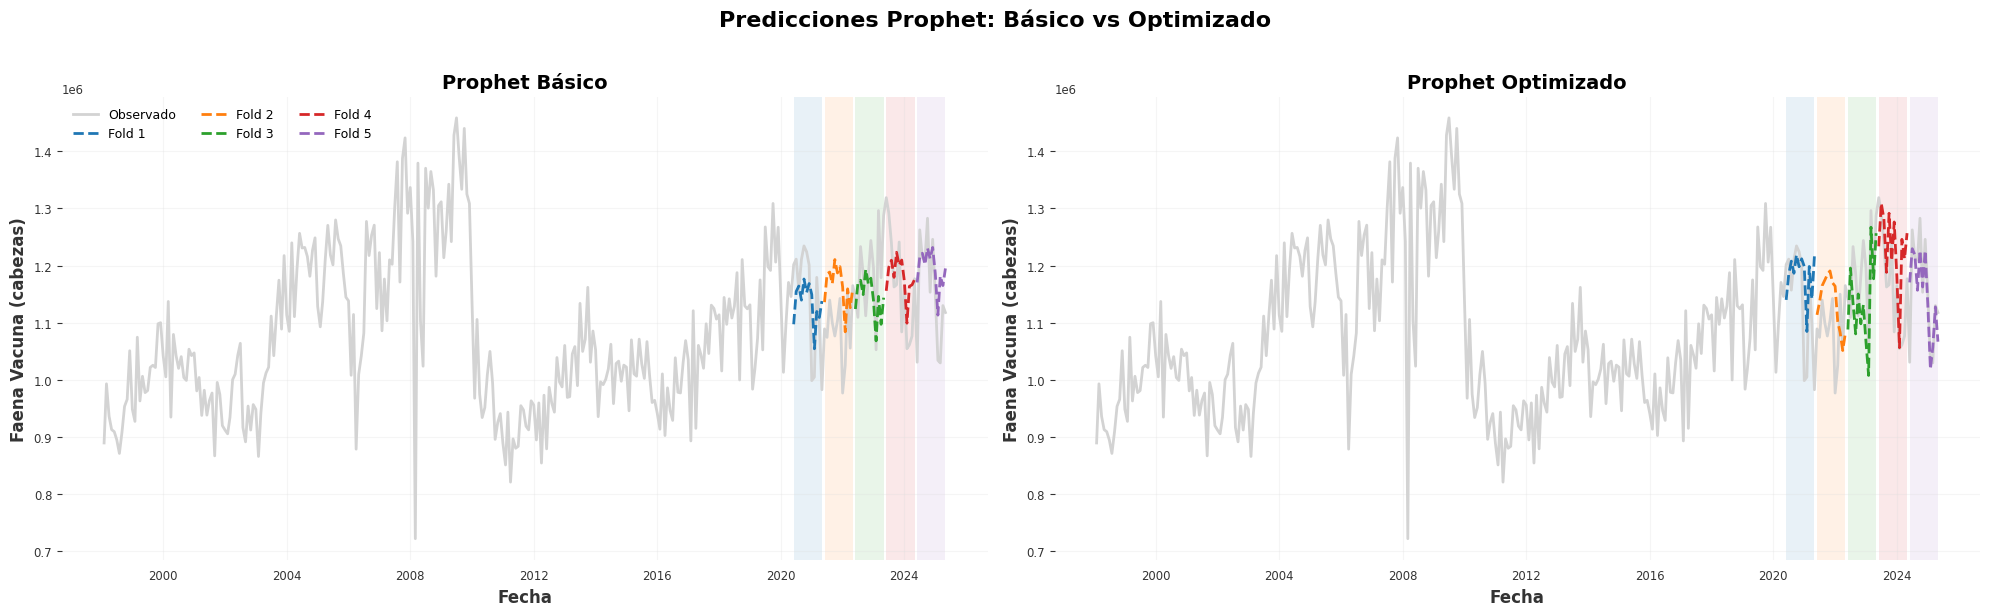

In [120]:
# ==================== GRÁFICOS FINALES ====================
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

prophet_models = [
    ('Prophet Básico', fold_preds_prophet_basic),
    ('Prophet Optimizado', fold_preds_prophet_opt)
]

for idx, (model_name, fold_preds) in enumerate(prophet_models):
    ax = axes[idx]
    
    # Serie observada completa
    ax.plot(df_prophet['ds'], df_prophet['y'], color='lightgray', label='Observado', linewidth=2)
    
    # Predicciones por fold
    for i, fold_df in enumerate(fold_preds):
        c = colors[i % len(colors)]
        ax.axvspan(fold_df['ds'].iloc[0], fold_df['ds'].iloc[-1], facecolor=c, alpha=0.1)
        ax.plot(fold_df['ds'], fold_df['y_pred'], color=c, linestyle='--', 
                linewidth=2, label=f'Fold {i+1}' if idx == 0 else '')
    
    ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Faena Vacuna (cabezas)', fontsize=12)
    if idx == 0:
        ax.legend(loc='upper left', ncol=3, fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Predicciones Prophet: Básico vs Optimizado', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [121]:
# ==================== TABLA COMPARATIVA FINAL DE TODOS LOS MODELOS ====================
print("="*70)
print("TABLA COMPARATIVA FINAL - TODOS LOS MODELOS")
print("="*70)

# Recopilar todos los resultados de RMSE y MAPE
resultados_finales = []

# 1. SARIMA
resultados_finales.append({
    'Categoría': 'Estadístico',
    'Modelo': 'SARIMA(1,1,1)(0,1,2)[12]',
    'RMSE_Promedio': 92579.44,
    'MAPE_Promedio': 6.69
})

# 2. Modelos ANN
resultados_finales.append({
    'Categoría': 'Deep Learning',
    'Modelo': 'MLP Básico',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_basic),
    'MAPE_Promedio': np.mean(mape_scores_mlp_basic)
})

resultados_finales.append({
    'Categoría': 'Deep Learning',
    'Modelo': 'MLP Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_optimized),
    'MAPE_Promedio': np.mean(mape_scores_mlp_optimized)
})

resultados_finales.append({
    'Categoría': 'Deep Learning',
    'Modelo': 'MLP Profundo',
    'RMSE_Promedio': np.mean(rmse_scores_mlp_deep),
    'MAPE_Promedio': np.mean(mape_scores_mlp_deep)
})

# 3. Modelos ML
resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'Random Forest Básico',
    'RMSE_Promedio': np.mean(rmse_scores_rf_basic),
    'MAPE_Promedio': np.mean(mape_scores_rf_basic)
})

resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'Random Forest Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_rf_opt),
    'MAPE_Promedio': np.mean(mape_scores_rf_opt)
})

resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'LightGBM Básico',
    'RMSE_Promedio': np.mean(rmse_scores_lgb_basic),
    'MAPE_Promedio': np.mean(mape_scores_lgb_basic)
})

resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'LightGBM Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_lgb_opt),
    'MAPE_Promedio': np.mean(mape_scores_lgb_opt)
})

resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'XGBoost Básico',
    'RMSE_Promedio': np.mean(rmse_scores_xgb_basic),
    'MAPE_Promedio': np.mean(mape_scores_xgb_basic)
})

resultados_finales.append({
    'Categoría': 'Machine Learning',
    'Modelo': 'XGBoost Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_xgb_opt),
    'MAPE_Promedio': np.mean(mape_scores_xgb_opt)
})

# 4. Prophet
resultados_finales.append({
    'Categoría': 'Time Series',
    'Modelo': 'Prophet Básico',
    'RMSE_Promedio': np.mean(rmse_scores_prophet_basic),
    'MAPE_Promedio': np.mean(mape_scores_prophet_basic)
})

resultados_finales.append({
    'Categoría': 'Time Series',
    'Modelo': 'Prophet Optimizado',
    'RMSE_Promedio': np.mean(rmse_scores_prophet_opt),
    'MAPE_Promedio': np.mean(mape_scores_prophet_opt)
})

# Crear DataFrame final
df_comparacion_final = pd.DataFrame(resultados_finales)

# Ordenar por MAPE (menor es mejor)
df_comparacion_final = df_comparacion_final.sort_values('MAPE_Promedio').reset_index(drop=True)

# Agregar ranking
df_comparacion_final['Ranking'] = range(1, len(df_comparacion_final) + 1)

print("📊 TABLA COMPARATIVA COMPLETA - TODOS LOS MODELOS:")
print("(Ordenados por MAPE ascendente - menor es mejor)")
print()

# Mostrar tabla formateada
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Formatear números para mejor visualización
df_display = df_comparacion_final.copy()
df_display['RMSE_Promedio'] = df_display['RMSE_Promedio'].apply(lambda x: f"{x:,.0f}")
df_display['MAPE_Promedio'] = df_display['MAPE_Promedio'].apply(lambda x: f"{x:.2f}%")

print(df_display[['Ranking', 'Categoría', 'Modelo', 'RMSE_Promedio', 'MAPE_Promedio']].to_string(index=False))

print("\n" + "="*70)
print("ANÁLISIS DE RESULTADOS:")
print("="*70)

# Identificar mejores modelos
mejor_mape = df_comparacion_final.iloc[0]
mejor_rmse = df_comparacion_final.loc[df_comparacion_final['RMSE_Promedio'].idxmin()]

print(f"🏆 MEJOR MODELO POR MAPE: {mejor_mape['Modelo']}")
print(f"   - MAPE: {mejor_mape['MAPE_Promedio']:.2f}%")
print(f"   - RMSE: {mejor_mape['RMSE_Promedio']:,.0f}")
print(f"   - Categoría: {mejor_mape['Categoría']}")

print(f"\n🏆 MEJOR MODELO POR RMSE: {mejor_rmse['Modelo']}")
print(f"   - RMSE: {mejor_rmse['RMSE_Promedio']:,.0f}")
print(f"   - MAPE: {mejor_rmse['MAPE_Promedio']:.2f}%")
print(f"   - Categoría: {mejor_rmse['Categoría']}")

# Análisis por categoría
print("\n📈 MEJORES MODELOS POR CATEGORÍA:")
for categoria in df_comparacion_final['Categoría'].unique():
    df_cat = df_comparacion_final[df_comparacion_final['Categoría'] == categoria]
    mejor_cat = df_cat.iloc[0]  # Ya está ordenado por MAPE
    print(f"   {categoria}: {mejor_cat['Modelo']} (MAPE: {mejor_cat['MAPE_Promedio']:.2f}%)")

# Comparación con benchmark SARIMA
sarima_mape = df_comparacion_final[df_comparacion_final['Modelo'].str.contains('SARIMA')]['MAPE_Promedio'].iloc[0]
mejores_que_sarima = df_comparacion_final[df_comparacion_final['MAPE_Promedio'] < sarima_mape]

print(f"\n📊 MODELOS QUE SUPERAN AL BENCHMARK SARIMA ({sarima_mape:.2f}% MAPE):")
if len(mejores_que_sarima) > 0:
    for _, modelo in mejores_que_sarima.iterrows():
        mejora = sarima_mape - modelo['MAPE_Promedio']
        print(f"   {modelo['Modelo']}: {modelo['MAPE_Promedio']:.2f}% (mejora: {mejora:.2f} puntos)")
else:
    print("   Ningún modelo supera al benchmark SARIMA")


TABLA COMPARATIVA FINAL - TODOS LOS MODELOS
📊 TABLA COMPARATIVA COMPLETA - TODOS LOS MODELOS:
(Ordenados por MAPE ascendente - menor es mejor)

 Ranking        Categoría                   Modelo RMSE_Promedio MAPE_Promedio
       1 Machine Learning Random Forest Optimizado        70,084         4.93%
       2 Machine Learning     Random Forest Básico        69,796         4.97%
       3 Machine Learning       XGBoost Optimizado        74,121         5.15%
       4 Machine Learning          LightGBM Básico        69,852         5.36%
       5 Machine Learning           XGBoost Básico        76,661         5.41%
       6 Machine Learning      LightGBM Optimizado        77,340         5.48%
       7      Time Series       Prophet Optimizado        81,906         5.71%
       8      Time Series           Prophet Básico        80,667         5.88%
       9    Deep Learning           MLP Optimizado        84,902         6.24%
      10      Estadístico SARIMA(1,1,1)(0,1,2)[12]        92,579  


VISUALIZACIÓN DE RESULTADOS


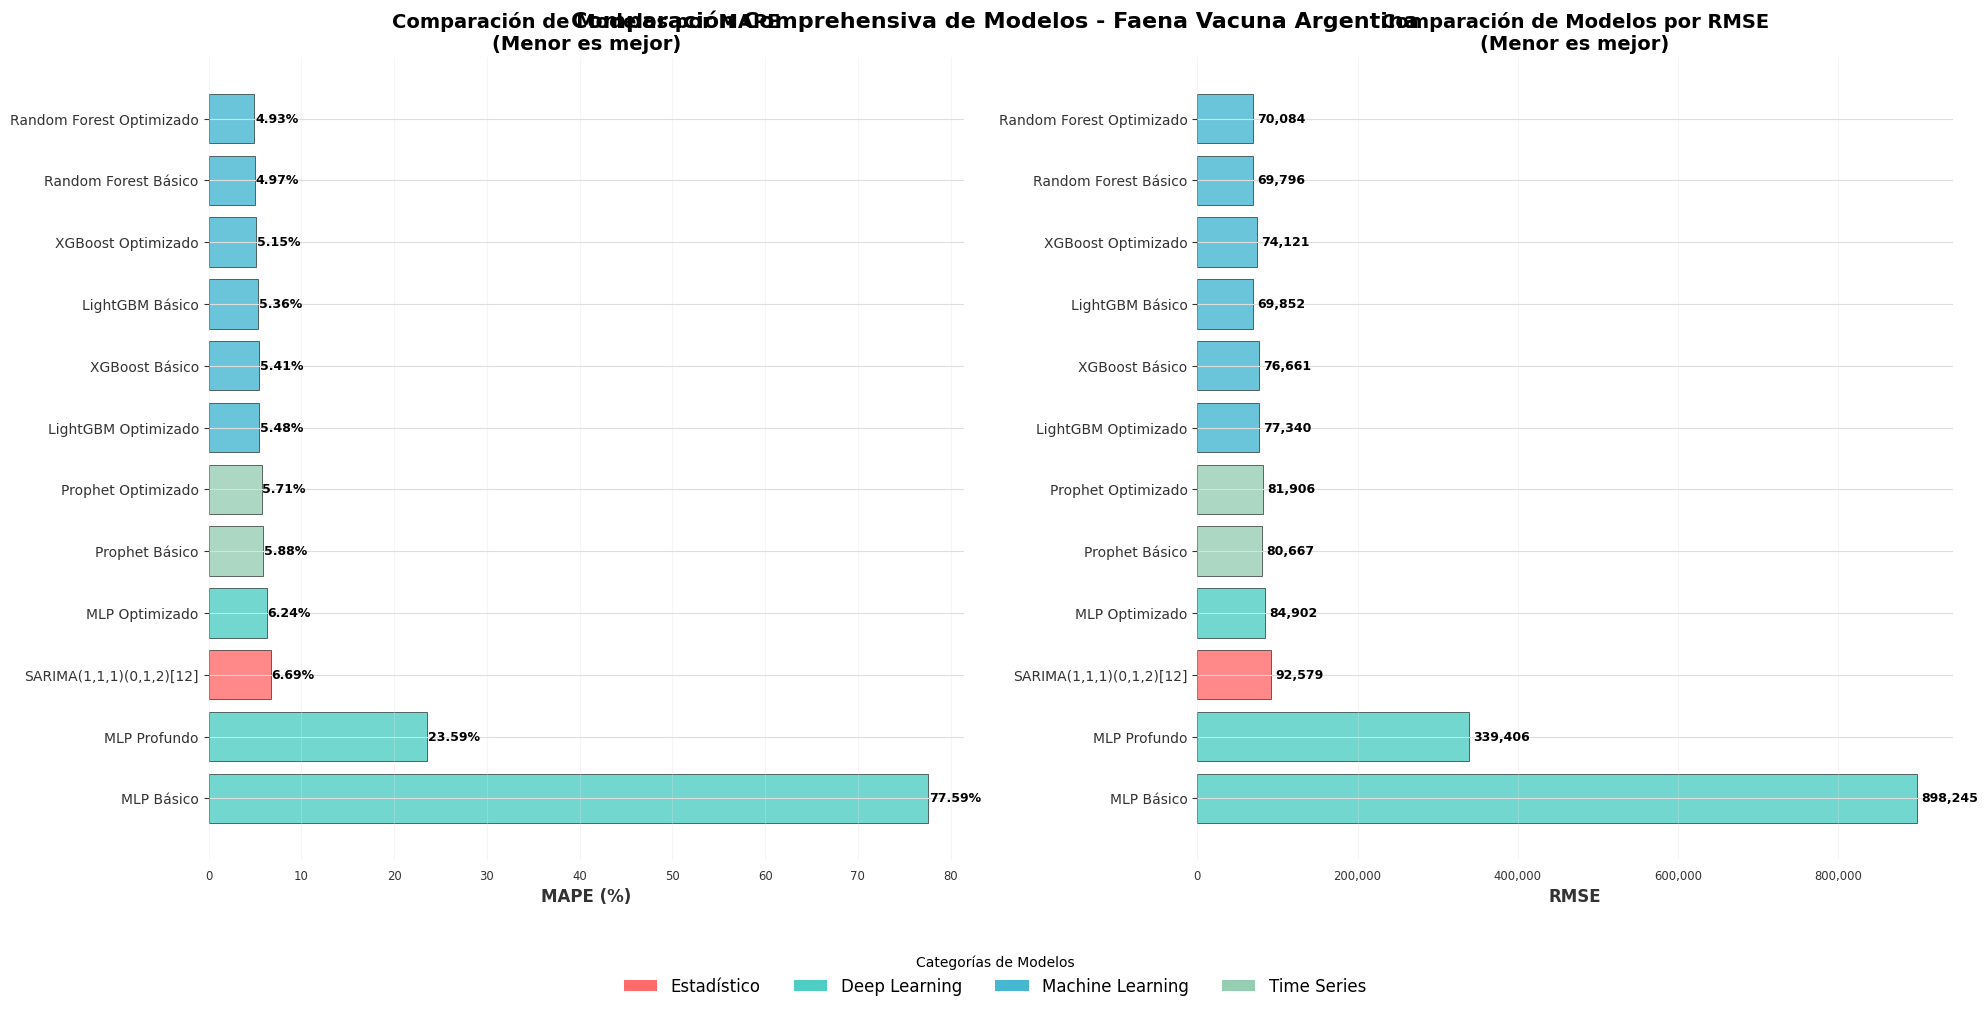


📈 ESTADÍSTICAS RESUMEN:
• Total de modelos evaluados: 12
• Rango MAPE: 4.93% - 77.59%
• Rango RMSE: 69,796 - 898,245
• Mejora máxima vs SARIMA: 1.76 puntos de MAPE

🥇 TOP 3 MODELOS:
   1. Random Forest Optimizado - MAPE: 4.93% | RMSE: 70,084
   2. Random Forest Básico - MAPE: 4.97% | RMSE: 69,796
   3. XGBoost Optimizado - MAPE: 5.15% | RMSE: 74,121


In [ ]:
# ==================== GRÁFICO COMPARATIVO FINAL ====================
print("\n" + "="*60)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*60)

# Crear gráfico de barras comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Paleta de colores por categoría
color_map = {
    'Estadístico': '#FF6B6B',
    'Deep Learning': '#4ECDC4', 
    'Machine Learning': '#45B7D1',
    'Time Series': '#96CEB4'
}

colors = [color_map[cat] for cat in df_comparacion_final['Categoría']]

# Gráfico 1: MAPE
bars1 = ax1.barh(range(len(df_comparacion_final)), df_comparacion_final['MAPE_Promedio'], 
                 color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(len(df_comparacion_final)))
ax1.set_yticklabels(df_comparacion_final['Modelo'], fontsize=10)
ax1.set_xlabel('MAPE (%)', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Modelos por MAPE\n(Menor es mejor)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Agregar valores en las barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}%', ha='left', va='center', fontweight='bold', fontsize=9)

# Gráfico 2: RMSE
bars2 = ax2.barh(range(len(df_comparacion_final)), df_comparacion_final['RMSE_Promedio'], 
                 color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(df_comparacion_final)))
ax2.set_yticklabels(df_comparacion_final['Modelo'], fontsize=10)
ax2.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('Comparación de Modelos por RMSE\n(Menor es mejor)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Formatear eje x para RMSE
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Agregar valores en las barras
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 5000, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}', ha='left', va='center', fontweight='bold', fontsize=9)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=categoria) 
                  for categoria, color in color_map.items()]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
           ncol=len(color_map), fontsize=12, title='Categorías de Modelos')

plt.suptitle('Comparación Comprehensiva de Modelos - Faena Vacuna Argentina', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

# Estadísticas resumen
print("\n📈 ESTADÍSTICAS RESUMEN:")
print(f"• Total de modelos evaluados: {len(df_comparacion_final)}")
print(f"• Rango MAPE: {df_comparacion_final['MAPE_Promedio'].min():.2f}% - {df_comparacion_final['MAPE_Promedio'].max():.2f}%")
print(f"• Rango RMSE: {df_comparacion_final['RMSE_Promedio'].min():,.0f} - {df_comparacion_final['RMSE_Promedio'].max():,.0f}")
print(f"• Mejora máxima vs SARIMA: {sarima_mape - df_comparacion_final['MAPE_Promedio'].min():.2f} puntos de MAPE")

# Top 3 modelos
print(f"\n🥇 TOP 3 MODELOS:")
for i in range(min(3, len(df_comparacion_final))):
    modelo = df_comparacion_final.iloc[i]
    print(f"   {i+1}. {modelo['Modelo']} - MAPE: {modelo['MAPE_Promedio']:.2f}% | RMSE: {modelo['RMSE_Promedio']:,.0f}")

----
> ### Análisis adicioanles sobre el modelo óptimo

Se observa que dentro del top de los modelos con mejores predicciones están el Random Forest Optimizado y el Random Forest Básico. La diferencia entre sus métricas de MAPE y RMSE son casi mínimas, así que se opta por el Random Forest Básico debido al criterio de parsimonia.

In [128]:
# ==================== 1. ENTRENAR MODELO FINAL SOBRE TODOS LOS DATOS ====================
print("\n1. Entrenando modelo final Random Forest Básico...")

# Parámetros del Random Forest básico (los mejores identificados)
rf_final_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'n_jobs': -1,
    'random_state': 123
}

# Entrenar sobre todos los datos disponibles
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)

rf_modelo_final = RandomForestRegressor(**rf_final_params)
rf_modelo_final.fit(X_scaled_final, y)

# Predicciones sobre todos los datos
y_pred_final = rf_modelo_final.predict(X_scaled_final)

print(f"✅ Modelo entrenado exitosamente")
print(f"   Observaciones utilizadas: {len(X)}")
print(f"   Features: {len(X.columns)}")
print(f"   R² Score: {rf_modelo_final.score(X_scaled_final, y):.3f}")



1. Entrenando modelo final Random Forest Básico...
✅ Modelo entrenado exitosamente
   Observaciones utilizadas: 322
   Features: 13
   R² Score: 0.891



2. Analizando importancia de variables...


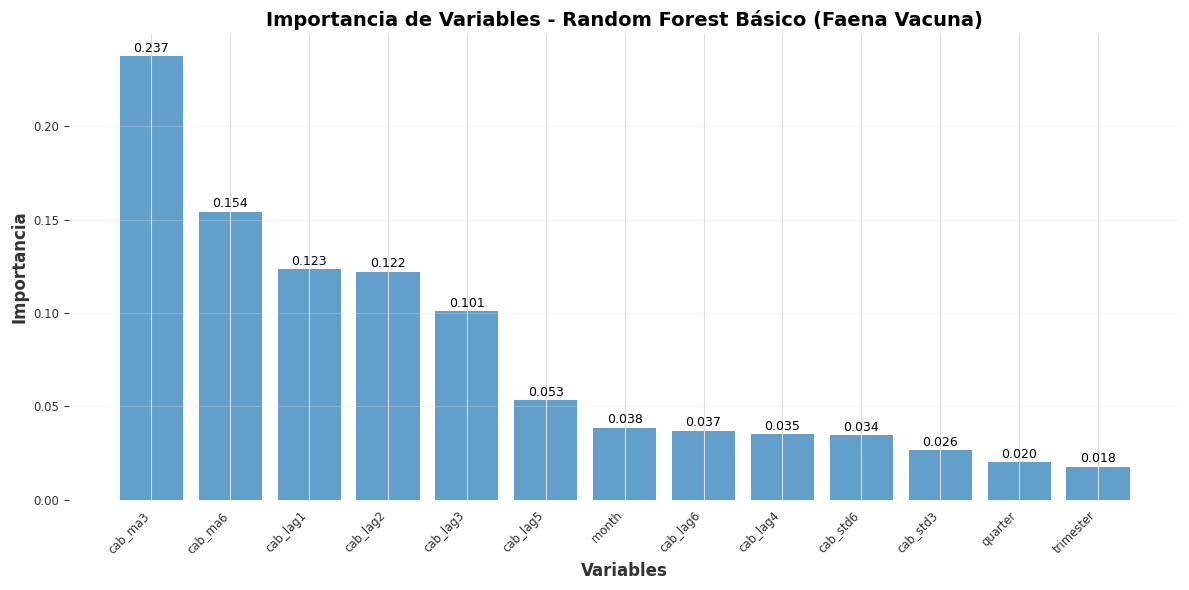


🔍 TOP 10 VARIABLES MÁS IMPORTANTES:
   1. cab_ma3        : 0.2374
   2. cab_ma6        : 0.1543
   3. cab_lag1       : 0.1234
   4. cab_lag2       : 0.1221
   5. cab_lag3       : 0.1010
   6. cab_lag5       : 0.0532
   7. month          : 0.0384
   8. cab_lag6       : 0.0369
   9. cab_lag4       : 0.0350
  10. cab_std6       : 0.0344


In [129]:
# ==================== 2. IMPORTANCIA DE VARIABLES ====================
print(f"\n2. Analizando importancia de variables...")

importancias = rf_modelo_final.feature_importances_
indices = np.argsort(importancias)[::-1]
features_names = X.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(features_names)), importancias[indices], color='tab:blue', alpha=0.7)
plt.xticks(range(len(features_names)), features_names[indices], rotation=45, ha='right')
plt.title("Importancia de Variables - Random Forest Básico (Faena Vacuna)", fontsize=14, fontweight='bold')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Importancia", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores encima de las barras
for i, v in enumerate(importancias[indices]):
    plt.text(i, v + max(importancias)*0.01, f'{v:.3f}', ha='center', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

# Mostrar top 10 variables más importantes
print(f"\n🔍 TOP 10 VARIABLES MÁS IMPORTANTES:")
for i in range(min(10, len(features_names))):
    idx = indices[i]
    print(f"  {i+1:2d}. {features_names[idx]:<15}: {importancias[idx]:.4f}")


3. Análisis Observado vs Predicho...


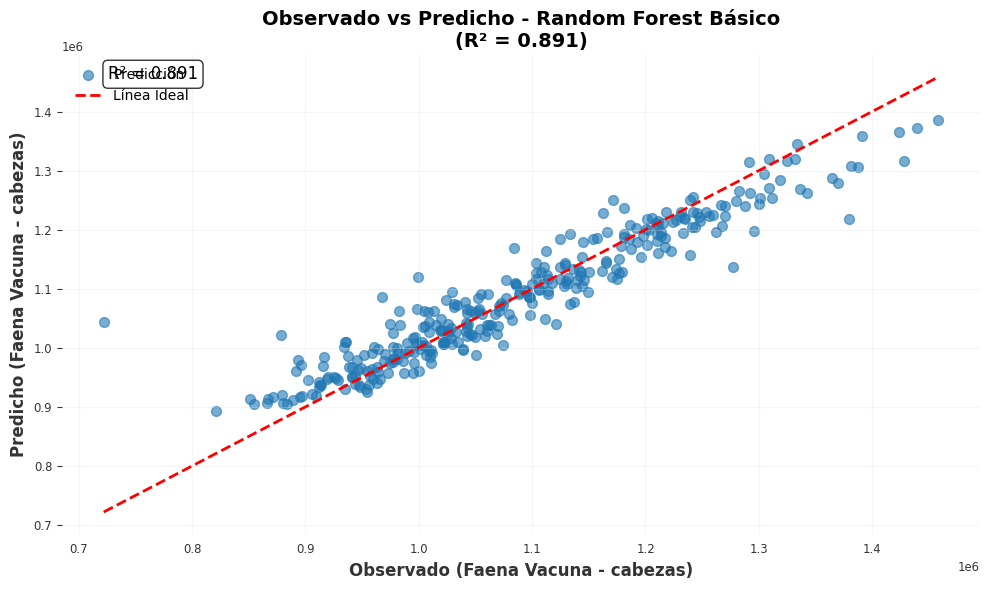

📊 Métricas del ajuste:
   R² Score: 0.8913
   RMSE: 43099.68
   MAPE: 2.87%


In [ ]:
# ==================== 3. OBSERVADO VS PREDICHO (TODOS LOS DATOS) ====================
print(f"\n3. Análisis Observado vs Predicho...")

r2_final = r2_score(y, y_pred_final)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_final, alpha=0.6, color='tab:blue', s=50, label='Predicción')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Línea Ideal')

# Añadir estadísticas al gráfico
plt.text(0.05, 0.95, f'R² = {r2_final:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title(f"Observado vs Predicho - Random Forest Básico\n(R² = {r2_final:.3f})", 
          fontsize=14, fontweight='bold')
plt.xlabel("Observado (Faena Vacuna - cabezas)", fontsize=12)
plt.ylabel("Predicho (Faena Vacuna - cabezas)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Métricas del ajuste:")
print(f"   R² Score: {r2_final:.4f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y, y_pred_final)):.2f}")
print(f"   MAPE: {safe_mape(y, y_pred_final):.2f}%")


4. Análisis de residuos...


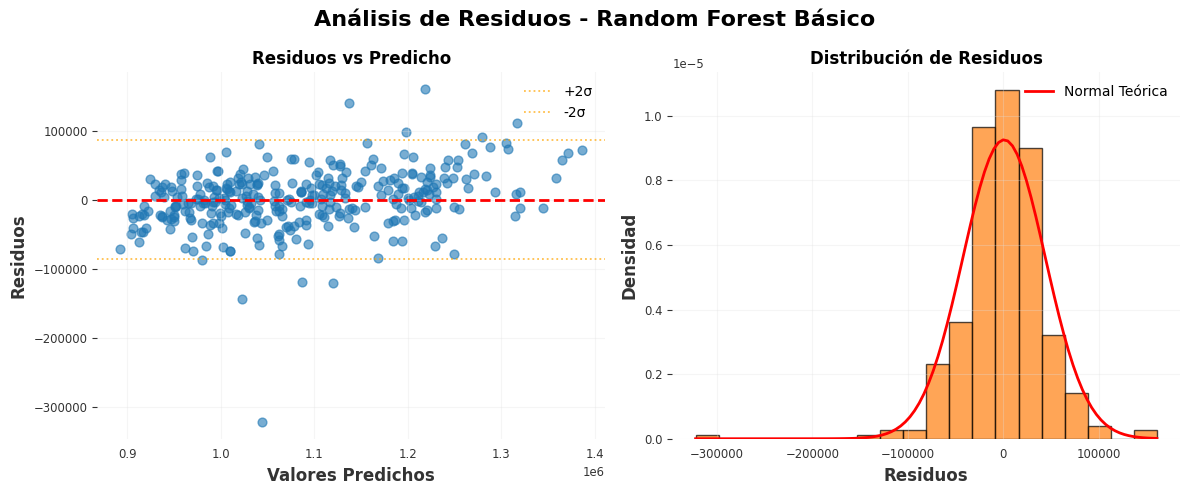


📊 ESTADÍSTICAS DE RESIDUOS:
   Media: 735.94
   Desviación estándar: 43093.40
   Mínimo: -322211.72
   Máximo: 160670.18
   Valores fuera de ±2σ: 10 (3.1%)


In [140]:
# ==================== 4. ANÁLISIS DE RESIDUOS ====================
print(f"\n4. Análisis de residuos...")

residuos = y - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuos vs Predicho
axes[0].scatter(y_pred_final, residuos, alpha=0.6, color='tab:blue', s=40)
axes[0].axhline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel("Valores Predichos", fontsize=12)
axes[0].set_ylabel("Residuos", fontsize=12)
axes[0].set_title("Residuos vs Predicho", fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Añadir líneas de referencia (±2σ)
std_residuos = np.std(residuos)
axes[0].axhline(2*std_residuos, color='orange', linestyle=':', alpha=0.7, label='+2σ')
axes[0].axhline(-2*std_residuos, color='orange', linestyle=':', alpha=0.7, label='-2σ')
axes[0].legend()

# Histograma de residuos
axes[1].hist(residuos, bins=20, edgecolor='k', color='tab:orange', alpha=0.7, density=True)
axes[1].set_xlabel("Residuos", fontsize=12)
axes[1].set_ylabel("Densidad", fontsize=12)
axes[1].set_title("Distribución de Residuos", fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Añadir curva normal teórica
x_norm = np.linspace(residuos.min(), residuos.max(), 100)
y_norm = (1/(np.sqrt(2*np.pi)*std_residuos)) * np.exp(-0.5*((x_norm - np.mean(residuos))/std_residuos)**2)
axes[1].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Teórica')
axes[1].legend()

plt.suptitle('Análisis de Residuos - Random Forest Básico', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\n📊 ESTADÍSTICAS DE RESIDUOS:")
print(f"   Media: {np.mean(residuos):.2f}")
print(f"   Desviación estándar: {std_residuos:.2f}")
print(f"   Mínimo: {np.min(residuos):.2f}")
print(f"   Máximo: {np.max(residuos):.2f}")
print(f"   Valores fuera de ±2σ: {np.sum(np.abs(residuos) > 2*std_residuos)} ({np.sum(np.abs(residuos) > 2*std_residuos)/len(residuos)*100:.1f}%)")

In [136]:
# ==================== 5. FORECAST CON RANDOM FOREST ====================
print(f"\n5. Generando forecast para los próximos 12 meses...")

n_forecast = 12
future_preds = []
lower_ci = []
upper_ci = []

# Obtener los árboles individuales del Random Forest
trees = rf_modelo_final.estimators_

# Crear DataFrame para el forecast
last_observation = X.iloc[-1:].copy()

print(f"Generando pronósticos paso a paso...")

for i in range(n_forecast):
    print(f"  Mes {i+1}/{n_forecast}...", end='')
    
    # Escalar las features
    X_next_scaled = scaler_final.transform(last_observation)
    
    # Obtener predicciones de todos los árboles individuales
    tree_preds = np.array([tree.predict(X_next_scaled)[0] for tree in trees])
    
    # Predicción promedio (la predicción del Random Forest)
    y_next = np.mean(tree_preds)
    
    # Calcular intervalos de confianza (percentiles de las predicciones de los árboles)
    ci_lower = np.percentile(tree_preds, 2.5)
    ci_upper = np.percentile(tree_preds, 97.5)
    
    future_preds.append(y_next)
    lower_ci.append(ci_lower)
    upper_ci.append(ci_upper)
    
    # Actualizar features para el siguiente paso
    # Mover los lags hacia atrás y añadir la nueva predicción
    new_observation = last_observation.copy()
    
    # Actualizar lags de cabezas
    for lag in range(6, 1, -1):  # De lag6 a lag2
        if f'cab_lag{lag}' in new_observation.columns:
            new_observation[f'cab_lag{lag}'] = last_observation[f'cab_lag{lag-1}'].iloc[0]
    
    # El nuevo lag1 es nuestra predicción actual
    if 'cab_lag1' in new_observation.columns:
        new_observation['cab_lag1'] = y_next
    
    # Actualizar medias móviles (aproximación)
    if 'cab_ma3' in new_observation.columns:
        new_observation['cab_ma3'] = (y_next + last_observation['cab_lag1'].iloc[0] + last_observation['cab_lag2'].iloc[0]) / 3
    if 'cab_ma6' in new_observation.columns:
        recent_values = [y_next, last_observation['cab_lag1'].iloc[0], last_observation['cab_lag2'].iloc[0], 
                        last_observation['cab_lag3'].iloc[0], last_observation['cab_lag4'].iloc[0], last_observation['cab_lag5'].iloc[0]]
        new_observation['cab_ma6'] = np.mean(recent_values)
    
    last_observation = new_observation
    print(" ✓")

# Convertir a arrays
future_preds = np.array(future_preds)
lower_ci = np.array(lower_ci)
upper_ci = np.array(upper_ci)

# Crear fechas para el forecast
last_date = y.index[-1]
fechas_forecast = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')



5. Generando forecast para los próximos 12 meses...
Generando pronósticos paso a paso...
  Mes 1/12... ✓
  Mes 2/12... ✓
  Mes 3/12... ✓
  Mes 4/12... ✓
  Mes 5/12... ✓
  Mes 6/12... ✓
  Mes 7/12... ✓
  Mes 8/12... ✓
  Mes 9/12... ✓
  Mes 10/12... ✓
  Mes 11/12... ✓
  Mes 12/12... ✓



6. Generando gráfico del forecast...


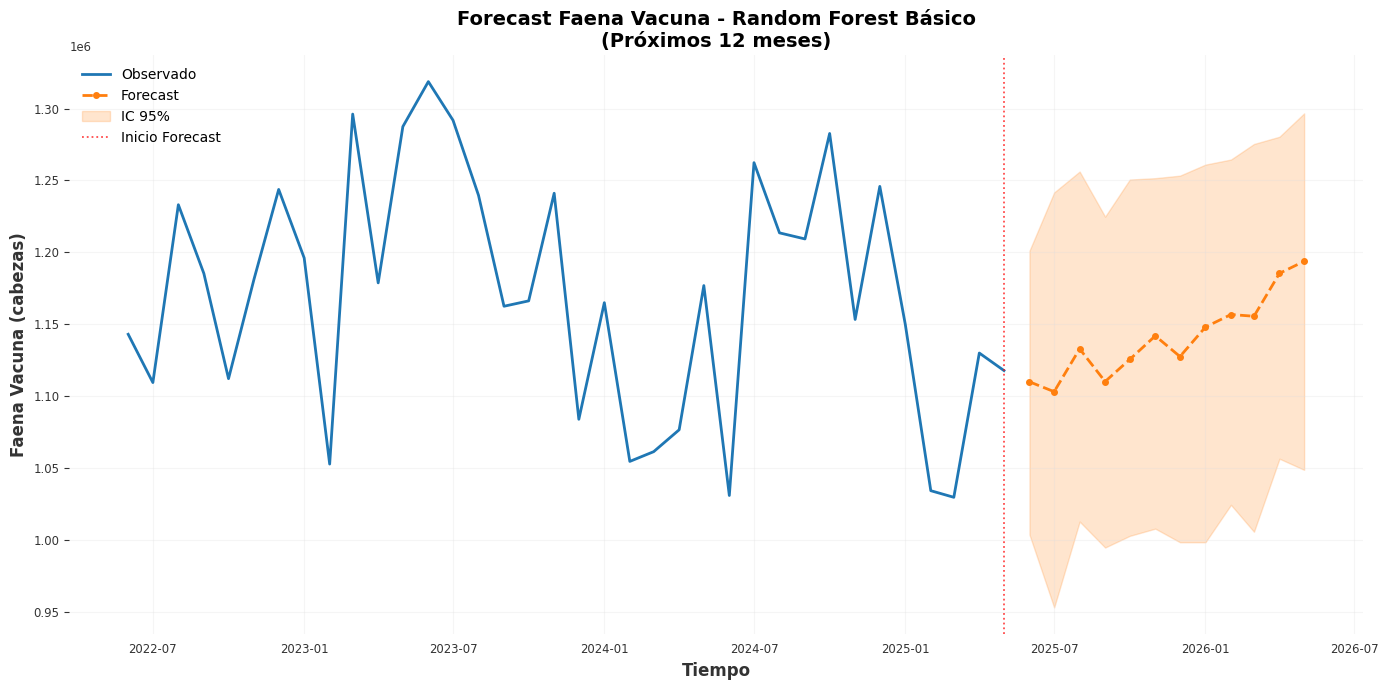

In [137]:
# ==================== 6. GRÁFICO DEL FORECAST ====================
print(f"\n6. Generando gráfico del forecast...")

plt.figure(figsize=(14, 7))

# Datos históricos (últimos 36 meses para mejor visualización)
lookback_months = 36
start_idx = max(0, len(y) - lookback_months)
y_recent = y.iloc[start_idx:]

plt.plot(y_recent.index, y_recent.values, label="Observado", color='tab:blue', linewidth=2)

# Predicciones futuras
plt.plot(fechas_forecast, future_preds, label="Forecast", linestyle='--', color='tab:orange', linewidth=2, marker='o', markersize=4)

# Intervalo de confianza
plt.fill_between(fechas_forecast, lower_ci, upper_ci, color='tab:orange', alpha=0.2, label='IC 95%')

# Línea vertical separando histórico de forecast
plt.axvline(x=y.index[-1], color='red', linestyle=':', alpha=0.7, label='Inicio Forecast')

plt.xlabel("Tiempo", fontsize=12)
plt.ylabel("Faena Vacuna (cabezas)", fontsize=12)
plt.title("Forecast Faena Vacuna - Random Forest Básico\n(Próximos 12 meses)", fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [138]:
# ==================== 7. TABLA DE RESULTADOS DEL FORECAST ====================
print(f"\n📋 TABLA DE PRONÓSTICOS:")
print("-" * 80)
print(f"{'Mes':<12} {'Fecha':<12} {'Predicción':<12} {'IC Inferior':<12} {'IC Superior':<12}")
print("-" * 80)

forecast_df = pd.DataFrame({
    'Fecha': fechas_forecast,
    'Predicción': future_preds,
    'IC_Inferior': lower_ci,
    'IC_Superior': upper_ci
})

for i, row in forecast_df.iterrows():
    print(f"{i+1:2d}         {row['Fecha'].strftime('%Y-%m'):<12} {row['Predicción']:>10.0f}   {row['IC_Inferior']:>10.0f}   {row['IC_Superior']:>10.0f}")



📋 TABLA DE PRONÓSTICOS:
--------------------------------------------------------------------------------
Mes          Fecha        Predicción   IC Inferior  IC Superior 
--------------------------------------------------------------------------------
 1         2025-06         1109893      1003578      1201040
 2         2025-07         1103006       952898      1241611
 3         2025-08         1132818      1012644      1256159
 4         2025-09         1110067       994577      1224784
 5         2025-10         1125496      1002694      1250598
 6         2025-11         1141841      1007716      1251563
 7         2025-12         1127466       998262      1253311
 8         2026-01         1147971       998262      1260994
 9         2026-02         1156695      1024279      1264523
10         2026-03         1155498      1005548      1275347
11         2026-04         1185334      1056372      1280389
12         2026-05         1193739      1048634      1296648


In [139]:
# ==================== 8. ESTADÍSTICAS DEL FORECAST ====================
print(f"\n📊 ESTADÍSTICAS DEL FORECAST:")
print("-" * 50)
print(f"Promedio pronóstico: {np.mean(future_preds):,.0f} cabezas")
print(f"Mínimo pronóstico: {np.min(future_preds):,.0f} cabezas")
print(f"Máximo pronóstico: {np.max(future_preds):,.0f} cabezas")
print(f"Desviación estándar: {np.std(future_preds):,.0f} cabezas")

# Comparar con estadísticas históricas
print(f"\nComparación con datos históricos:")
print(f"Promedio histórico: {np.mean(y):,.0f} cabezas")
print(f"Desviación histórica: {np.std(y):,.0f} cabezas")

cambio_promedio = (np.mean(future_preds) - np.mean(y)) / np.mean(y) * 100
print(f"Cambio promedio esperado: {cambio_promedio:+.1f}%")


📊 ESTADÍSTICAS DEL FORECAST:
--------------------------------------------------
Promedio pronóstico: 1,140,819 cabezas
Mínimo pronóstico: 1,103,006 cabezas
Máximo pronóstico: 1,193,739 cabezas
Desviación estándar: 27,554 cabezas

Comparación con datos históricos:
Promedio histórico: 1,086,358 cabezas
Desviación histórica: 130,731 cabezas
Cambio promedio esperado: +5.0%
